<a href="https://colab.research.google.com/github/Mariam-Elbishbeashy/Healthcare-Classification-ML/blob/main/HealthCareTask2_with_pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
import seaborn as sns

from sklearn.naive_bayes import MultinomialNB
import matplotlib.pyplot as plt


In [21]:
from google.colab import drive
drive.mount('/content/drive')

df = pd.read_csv('/content/drive/MyDrive/healthcare/train data.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ID                  50000 non-null  int64  
 1   Name                50000 non-null  object 
 2   Age                 50000 non-null  int64  
 3   Gender              50000 non-null  object 
 4   Blood Type          46935 non-null  object 
 5   Medical Condition   50000 non-null  object 
 6   Date of Admission   50000 non-null  object 
 7   Doctor              49196 non-null  object 
 8   Hospital            49041 non-null  object 
 9   Insurance Provider  49707 non-null  object 
 10  Billing Amount      49276 non-null  float64
 11  Room Number         50000 non-null  int64  
 12  Admission Type      49819 non-null  object 
 13  Discharge Date      50000 non-null  object 
 14  Medication          50000 non-null  object 
 15  Test Results        50000 non-null  obj

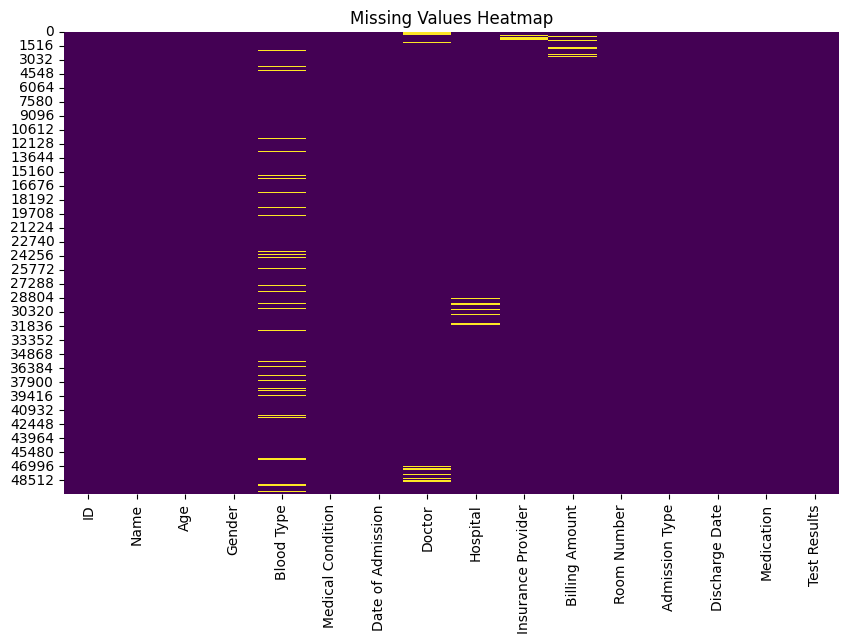

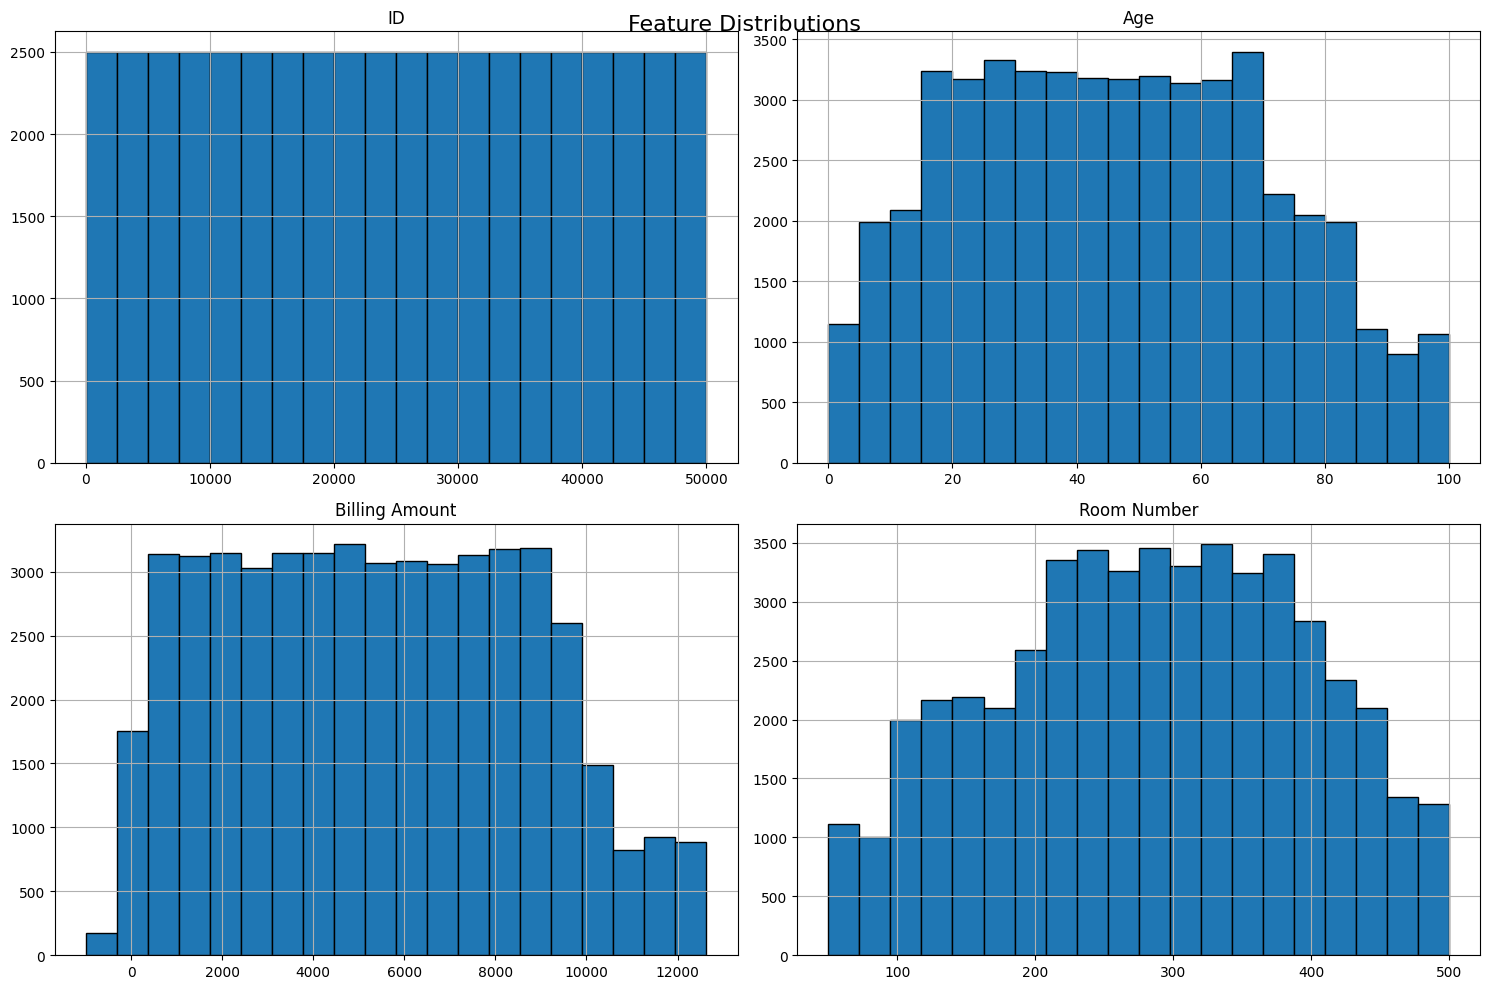

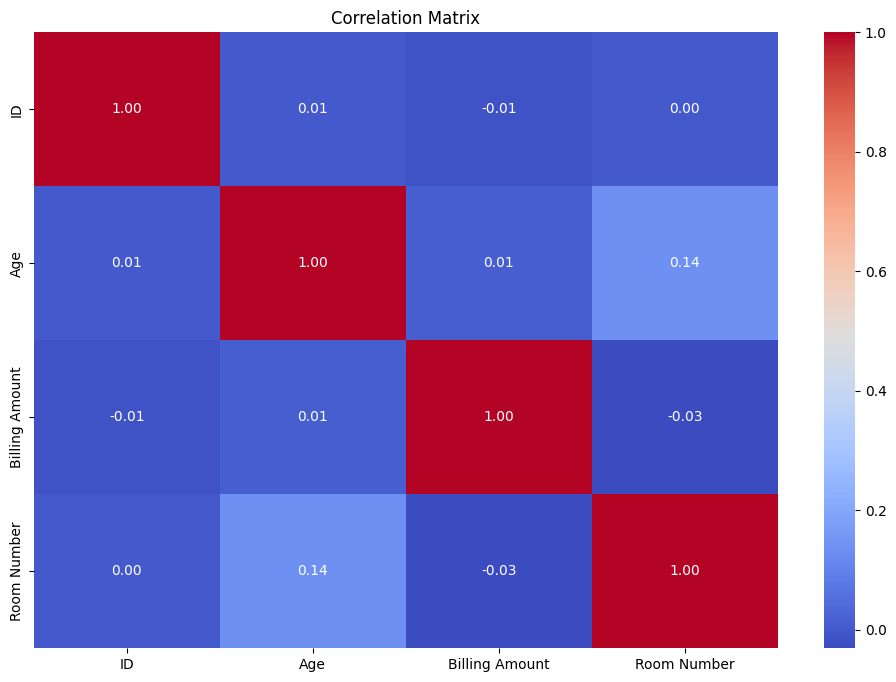

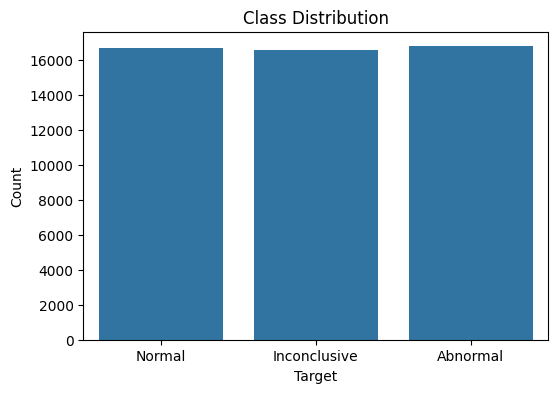

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

# Display basic info
print("Dataset Info:")
df.info()

# Check for missing values
plt.figure(figsize=(10, 6))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Values Heatmap')
plt.show()

# Histogram for each numerical column
df.hist(figsize=(15, 10), bins=20, edgecolor='black')
plt.tight_layout()
plt.suptitle('Feature Distributions', fontsize=16)
plt.show()

# Correlation matrix (for numeric features)
plt.figure(figsize=(12, 8))
sns.heatmap(df.select_dtypes(include='number').corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

# Target class distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='Test Results', data=df)
plt.title('Class Distribution')
plt.xlabel('Target')
plt.ylabel('Count')
plt.show()

In [23]:
df.shape


(50000, 16)

In [24]:
df.head()

,ID,Name,Age,Gender,Blood Type,Medical Condition,Date of Admission,Doctor,Hospital,Insurance Provider,Billing Amount,Room Number,Admission Type,Discharge Date,Medication,Test Results
0,1,Bobby JacksOn,27,Female,O-,Asthma,06/06/2022,Mark Hartman Jr.,Sons and Miller,Cigna,2625.980554,379,Elective,18/08/2022,Ibuprofen,Normal
1,2,LesLie TErRy,68,Female,O-,Cancer,19/11/2021,Angela Contreras,White-White,Cigna,1471.387317,113,Elective,20/11/2021,Ibuprofen,Inconclusive
2,3,DaNnY sMitH,21,Female,A+,Hypertension,05/03/2022,David Ruiz,Group Middleton,Medicare,5131.488104,154,Emergency,16/05/2022,Paracetamol,Normal
3,4,andrEw waTtS,91,Male,AB-,Diabetes,06/04/2020,Jenny Griffith,Morris-Arellano,Blue Cross,8972.793157,293,Urgent,26/04/2020,Ibuprofen,Abnormal
4,5,adrIENNE bEll,52,Female,A+,Diabetes,31/12/2022,Cynthia Scott,Williams-Davis,Blue Cross,2015.522684,265,Emergency,11/02/2023,Penicillin,Abnormal


In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ID                  50000 non-null  int64  
 1   Name                50000 non-null  object 
 2   Age                 50000 non-null  int64  
 3   Gender              50000 non-null  object 
 4   Blood Type          46935 non-null  object 
 5   Medical Condition   50000 non-null  object 
 6   Date of Admission   50000 non-null  object 
 7   Doctor              49196 non-null  object 
 8   Hospital            49041 non-null  object 
 9   Insurance Provider  49707 non-null  object 
 10  Billing Amount      49276 non-null  float64
 11  Room Number         50000 non-null  int64  
 12  Admission Type      49819 non-null  object 
 13  Discharge Date      50000 non-null  object 
 14  Medication          50000 non-null  object 
 15  Test Results        50000 non-null  object 
dtypes: f

In [26]:
# Set pandas to display all columns and rows
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Show number of missing values for all 16 features
print(df.isnull().sum())

ID                       0
Name                     0
Age                      0
Gender                   0
Blood Type            3065
Medical Condition        0
Date of Admission        0
Doctor                 804
Hospital               959
Insurance Provider     293
Billing Amount         724
Room Number              0
Admission Type         181
Discharge Date           0
Medication               0
Test Results             0
dtype: int64


In [27]:
!pip install gender-guesser
from gender_guesser.detector import Detector

detector = Detector()

def infer_gender(name):
    name_lower = name.lower()

    # Check for titles
    if name_lower.startswith('mrs.') or name_lower.startswith('ms.'):
        return 'Female'
    elif name_lower.startswith('mr.'):
        return 'Male'

    # If no title, use first name with gender_guesser
    first = name.split()[0]
    g = detector.get_gender(first)
    if g in ('male', 'mostly_male'):
        return 'Male'
    elif g in ('female', 'mostly_female'):
        return 'Female'

    return None  # Skip uncertain guesses

# Apply inference
df['Inferred Gender'] = df['Name'].map(infer_gender)

# Update only where inference is confident and different from existing
mismatches = df[
    df['Inferred Gender'].notnull() &
    (df['Inferred Gender'] != df['Gender'])
]

df.loc[mismatches.index, 'Gender'] = df.loc[mismatches.index, 'Inferred Gender']


In [28]:
for column in df.columns:
    print(f"Unique values in column '{column}':")
    print(df[column].unique())
    print("-" * 30)

Unique values in column 'ID':
[    1     2     3 ... 49998 49999 50000]
------------------------------
Unique values in column 'Name':
['Bobby JacksOn' 'LesLie TErRy' 'DaNnY sMitH' ... 'LiSa sIMPsoN'
 'RoGER farRELl' 'kaTheRIne WeBSTer']
------------------------------
Unique values in column 'Age':
[ 27  68  21  91  52  29  58  53  56  80  66  36  32  74   6  86  99  34
  82  55   4  17  28  64  71  25  47  39  37   2  61  33  78  63  84  70
  76  22  18   8  15  94  45  31  72  19  16  26  43  23  65  35  85   3
   7  40  73   0   5  24  97  11   1   9  41  38  46  12  14  13  51  79
  60  89  54  30  48  83  69  49  59  50  81  44 100  62  20  10  42  77
  57  90  98  67  95  93  75  96  87  88  92]
------------------------------
Unique values in column 'Gender':
['Male' 'Female']
------------------------------
Unique values in column 'Blood Type':
['O-' 'A+' 'AB-' 'B-' 'O+' 'A-' 'AB+' 'B+' nan]
------------------------------
Unique values in column 'Medical Condition':
['Asthma' 'Ca

In [29]:
# Check how many values have exactly 5 decimals
df['Billing Amount'].astype(str).str.extract(r'\.(\d+)$')[0].str.len().value_counts()

,count
0,
6.0,36927
5.0,7203
7.0,3971
4.0,679
8.0,381
3.0,67
9.0,37
2.0,10
1.0,1


In [30]:
def normalize_billing(value):
    decimals = len(str(value).split('.')[-1]) if '.' in str(value) else 0

    if decimals > 5:
        # Scale it up to reduce decimal places
        factor = 10 ** (decimals - 5)
        return value * factor
    elif decimals < 5:
        # Scale it down to increase decimal precision
        factor = 10 ** (5 - decimals)
        return value / factor
    else:
        return value  # already fine

# Apply fix
df['Billing Amount'] = df['Billing Amount'].abs().apply(normalize_billing)

In [31]:
# Check how many values have exactly 5 decimals
df['Billing Amount'].astype(str).str.extract(r'\.(\d+)$')[0].str.len().value_counts()

,count
0,
5.0,38025
12.0,6752
11.0,4236
13.0,200
14.0,58
15.0,5


#Pipeline

In [32]:
import pandas as pd
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.base import BaseEstimator, TransformerMixin
import pandas as pd

class FrequencyEncoder(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        # Ensure input is DataFrame
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X)
        self.freq_maps_ = [
            col.value_counts(normalize=True).to_dict()
            for _, col in X.items()
        ]
        return self

    def transform(self, X):
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X)
        X_out = pd.DataFrame()
        for i, col in enumerate(X.columns):
            X_out[col] = X.iloc[:, i].map(self.freq_maps_[i]).fillna(0)
        return X_out.values  # Return NumPy array to work in pipelines


# --- Data Preprocessing ---
# Convert dates and create length of stay
df['Date of Admission'] = pd.to_datetime(df['Date of Admission'], dayfirst=True)
df['Discharge Date'] = pd.to_datetime(df['Discharge Date'], dayfirst=True)
df['Length of Stay'] = (df['Discharge Date'] - df['Date of Admission']).dt.days


# Drop unnecessary columns
df = df.drop(columns=['Name', 'Date of Admission', 'Discharge Date', 'Room Number'])

# Target
y = df['Test Results']
X = df.drop(columns=['Test Results'])

# Define encoding groups
onehot_cols = ['Gender', 'Insurance Provider']
ordinal_cols = ['Admission Type']
freq_cols = ['Doctor', 'Hospital', 'Medical Condition', 'Medication']
numeric_cols = ['Age', 'Billing Amount', 'Length of Stay']

# Define transformers
binary_gender_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('binary', OrdinalEncoder())  # Will map Male/Female to 0/1 or similar
])

onehot_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

ordinal_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ordinal', OrdinalEncoder(categories=[['Elective', 'Urgent', 'Emergency']]))
])

freq_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('freq', FrequencyEncoder())
])

numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Combine all into a single preprocessor
preprocessor = ColumnTransformer(transformers=[
    ('gender_bin', binary_gender_transformer, ['Gender']),
    ('onehot', onehot_transformer, ['Insurance Provider']),
    ('ordinal', ordinal_transformer, ordinal_cols),
    ('freq', freq_transformer, freq_cols),
    ('num', numeric_transformer, numeric_cols)
])


In [33]:
print(df.columns.tolist())


['ID', 'Age', 'Gender', 'Blood Type', 'Medical Condition', 'Doctor', 'Hospital', 'Insurance Provider', 'Billing Amount', 'Admission Type', 'Medication', 'Test Results', 'Inferred Gender', 'Length of Stay']


In [34]:
# Drop rows where ALL values are null (entire row is empty)
df = df.dropna(how='all')

# Verify the new shape (should be 50,000 rows now)
print("New shape after dropping null rows:", df.shape)  # Expected: (50000, 16)

# Confirm no fully null rows remain
print("\nNull counts after cleaning:")
print(df.isnull().sum())

New shape after dropping null rows: (50000, 14)

Null counts after cleaning:
ID                        0
Age                       0
Gender                    0
Blood Type             3065
Medical Condition         0
Doctor                  804
Hospital                959
Insurance Provider      293
Billing Amount          724
Admission Type          181
Medication                0
Test Results              0
Inferred Gender       48161
Length of Stay            0
dtype: int64


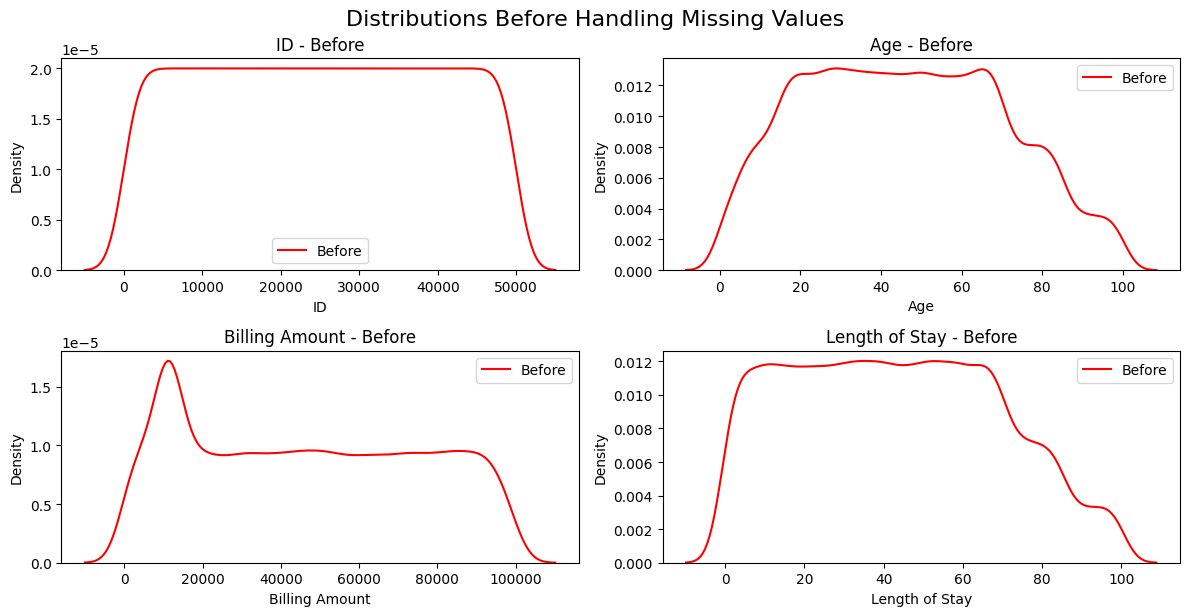

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns

numeric_cols = df.select_dtypes(include='number').columns
n_cols = 2
n_rows = (len(numeric_cols) + 1) // n_cols  # arrange nicely

# Plot Before distributions
fig_before, axes_before = plt.subplots(n_rows, n_cols, figsize=(12, n_rows * 3))
axes_before = axes_before.flatten()

for i, col in enumerate(numeric_cols):
    sns.kdeplot(df[col], ax=axes_before[i], color='red', label='Before')
    axes_before[i].set_title(f'{col} - Before')
    axes_before[i].legend()

# Hide unused subplots if any
for j in range(i+1, n_rows * n_cols):
    axes_before[j].axis('off')

plt.tight_layout()
plt.suptitle('Distributions Before Handling Missing Values', y=1.02, fontsize=16)
plt.show()

In [36]:
# # Replace nulls in categorical columns by reassignment
# df['Blood Type'] = df['Blood Type'].fillna('Unknown')
# df['Doctor'] = df['Doctor'].fillna('Unknown')
# df['Hospital'] = df['Hospital'].fillna('Unknown')
# df['Insurance Provider'] = df['Insurance Provider'].fillna('Self-Pay')
# df['Admission Type'] = df['Admission Type'].fillna('Unknown')

# # For Billing Amount, drop nulls
# df.dropna(subset=['Billing Amount'], inplace=True)

In [37]:
print("\nNull counts after imputation:")
print(df.isnull().sum())


Null counts after imputation:
ID                        0
Age                       0
Gender                    0
Blood Type             3065
Medical Condition         0
Doctor                  804
Hospital                959
Insurance Provider      293
Billing Amount          724
Admission Type          181
Medication                0
Test Results              0
Inferred Gender       48161
Length of Stay            0
dtype: int64


## Viewing data

In [38]:
preprocessor.fit(X)
X_transformed = preprocessor.transform(X)

print(X_transformed)

[[ 1.          0.          0.         ... -0.77259979 -0.69056708
   1.17387624]
 [ 0.          0.          0.         ...  0.90663553 -1.08659181
  -1.61112077]
 [ 0.          0.          0.         ... -1.01834154  0.16882038
   1.13519572]
 ...
 [ 0.          0.          1.         ...  1.07046337 -0.96826474
   0.36158544]
 [ 0.          1.          0.         ... -1.46886809 -1.11148181
  -0.25730278]
 [ 1.          1.          0.         ... -1.87843768 -0.02356027
   0.86443212]]


In [39]:
import pandas as pd

# Convert to DataFrame
X_out = pd.DataFrame(X_transformed)
X_out.head()


,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.01056,0.02700,0.22970,0.18520,-0.772600,-0.690567,1.173876
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.02778,0.04216,0.18370,0.18520,0.906636,-1.086592,-1.611121
2,0.0,0.0,0.0,0.0,1.0,0.0,2.0,0.00698,0.03122,0.14940,0.19112,-1.018342,0.168820,1.135196
3,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.00132,0.02846,0.13604,0.18520,1.848646,1.486386,-0.876191
4,0.0,0.0,1.0,0.0,0.0,0.0,2.0,0.00720,0.02700,0.13604,0.24516,0.251324,-0.899954,-0.025220


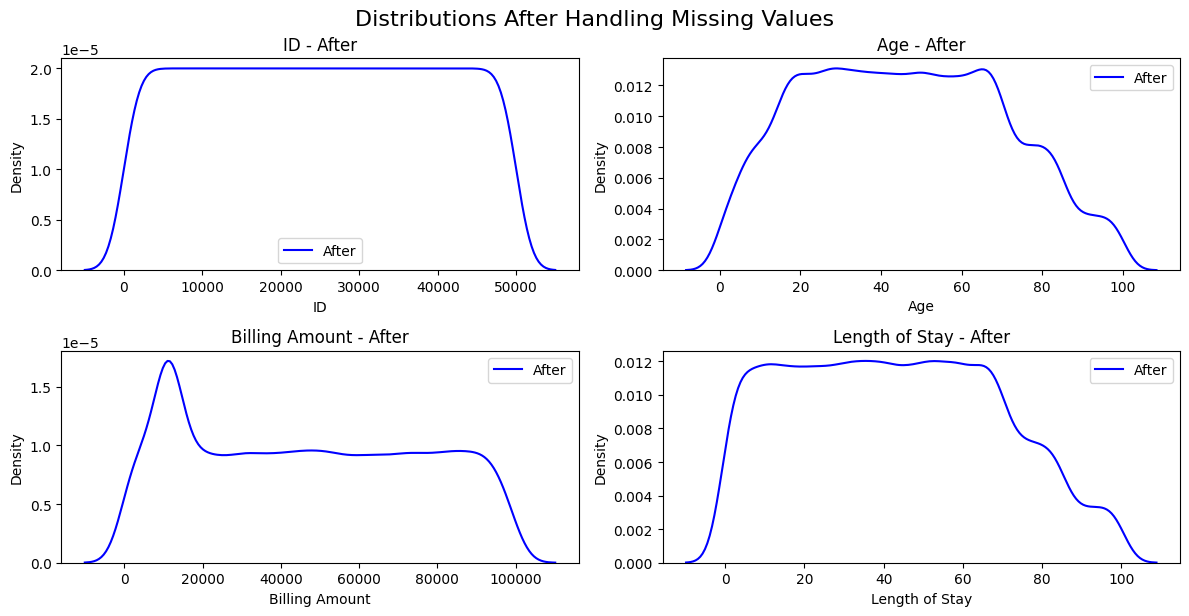

In [40]:
# Plot After distributions
fig_after, axes_after = plt.subplots(n_rows, n_cols, figsize=(12, n_rows * 3))
axes_after = axes_after.flatten()

for i, col in enumerate(numeric_cols):
    sns.kdeplot(df[col], ax=axes_after[i], color='blue', label='After')
    axes_after[i].set_title(f'{col} - After')
    axes_after[i].legend()

# Hide unused subplots if any
for j in range(i+1, n_rows * n_cols):
    axes_after[j].axis('off')

plt.tight_layout()
plt.suptitle('Distributions After Handling Missing Values', y=1.02, fontsize=16)
plt.show()

# Handling Blood Type Missing Rows

In [41]:
import pandas as pd
print(df[df['Blood Type'].isnull()].groupby(['Hospital', 'Admission Type']).size())

Hospital                        Admission Type
Beck-Galloway                   Elective           2
                                Emergency          4
                                Urgent             6
Brown, and Jones Weaver         Elective           8
                                Emergency         12
                                Urgent            27
Cervantes-Wells                 Elective          23
                                Emergency         19
                                Urgent            39
Clark-Mayo                      Elective           4
                                Emergency         19
                                Urgent            41
Cline-Williams                  Elective          21
                                Emergency         26
                                Urgent            82
Cook PLC                        Elective           7
                                Emergency         31
                                Urgent            29

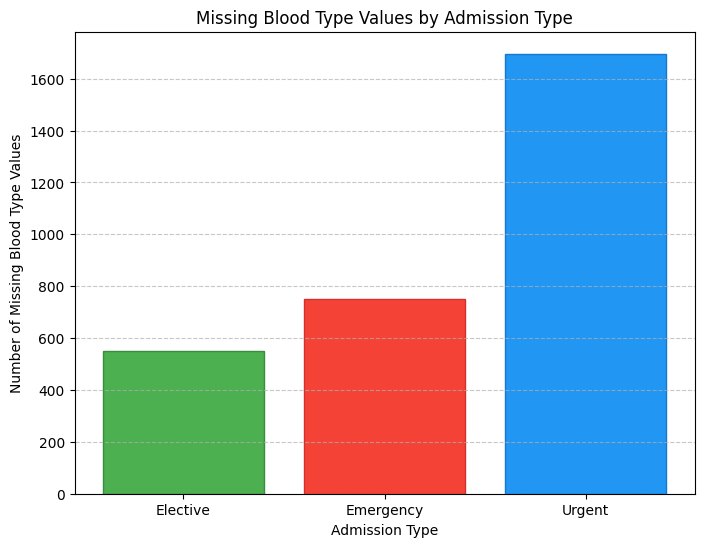

In [42]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming df is your dataset; load it if not already loaded
# df = pd.read_csv('your_dataset.csv')  # Uncomment and update path if needed

# Group by Hospital and Admission Type, get size of missing Blood Type values
missing_data = df[df['Blood Type'].isnull()].groupby(['Hospital', 'Admission Type']).size()

# Aggregate by Admission Type to get total missing values for each type
missing_by_admission = missing_data.groupby('Admission Type').sum()

# Prepare data for plotting
admission_types = missing_by_admission.index
missing_counts = missing_by_admission.values

# Create bar chart
plt.figure(figsize=(8, 6))
bars = plt.bar(admission_types, missing_counts, color=['#4CAF50', '#F44336', '#2196F3'], edgecolor=['#388E3C', '#D32F2F', '#1976D2'], linewidth=1)

# Customize the plot
plt.title('Missing Blood Type Values by Admission Type')
plt.xlabel('Admission Type')
plt.ylabel('Number of Missing Blood Type Values')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.show()


In [43]:
print(df['Admission Type'].unique())

['Elective' 'Emergency' 'Urgent' nan]



Crosstab of Blood Type vs Test Results:
Test Results  Abnormal  Inconclusive  Normal
Blood Type                                  
A+                 849          2552    3472
A-                1684           830     834
AB+                816          3331     823
AB-               3321           813    1605
B+                 818           771    1689
B-                3346          4063    4929
O+                2088          1485     983
O-                2529          1689    1615


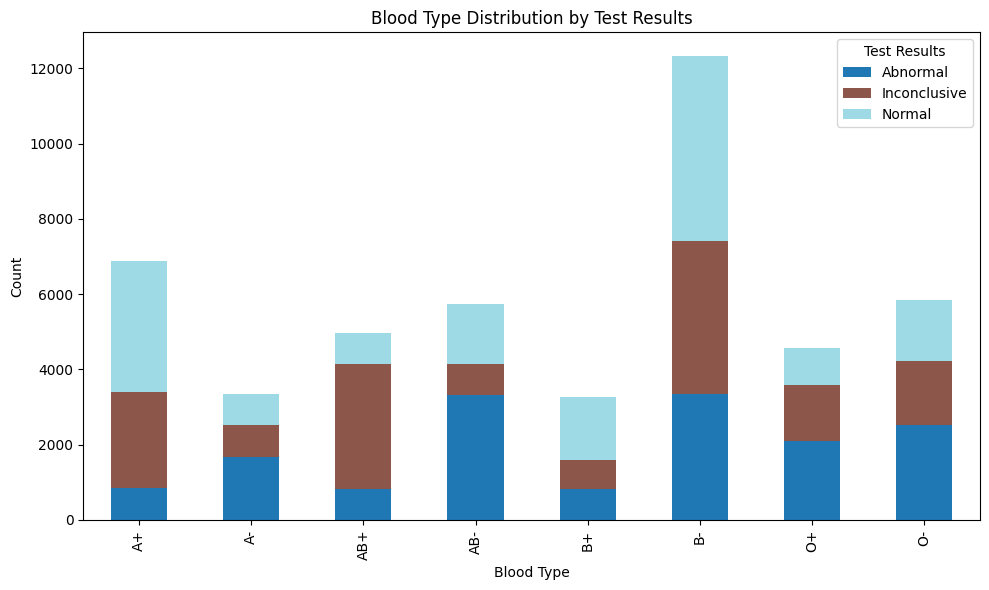

In [44]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming df is your dataset
# df = pd.read_csv('your_dataset.csv')  # Uncomment if needed

# Create crosstab of Blood Type vs Test Results
crosstab = pd.crosstab(df['Blood Type'], df['Test Results'])

# Display the crosstab
print("\nCrosstab of Blood Type vs Test Results:")
print(crosstab)

# Visualize as a stacked bar chart
crosstab.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='tab20')
plt.title('Blood Type Distribution by Test Results')
plt.xlabel('Blood Type')
plt.ylabel('Count')
plt.legend(title='Test Results')
plt.tight_layout()
plt.show()

In [45]:
# Filter the DataFrame to include only rows where 'Test Results' is 'Inconclusive'
inconclusive_results = df[df['Test Results'] == 'Inconclusive']

# Count how many of these rows have 'Blood Type' as null
inconclusive_blood_type_null_count = inconclusive_results['Blood Type'].isnull().sum()

print(f"\nNumber of inconclusive test results with null blood type: {inconclusive_blood_type_null_count}")


Number of inconclusive test results with null blood type: 1010


In [46]:
# Get the distribution of known blood types
known_blood_types = df[df['Blood Type'] != 'Unknown']['Blood Type']
prob_dist = known_blood_types.value_counts(normalize=True)

# Get indices where blood type is unknown
unknown_indices = df[df['Blood Type'] == 'Unknown'].index

# Randomly assign blood types to 'Unknown' based on real distribution
np.random.seed(0)  # for reproducibility
df.loc[unknown_indices, 'Blood Type'] = np.random.choice(
    prob_dist.index, size=len(unknown_indices), p=prob_dist.values
)


Crosstab of Blood Type vs Test Results:
Test Results  Abnormal  Inconclusive  Normal
Blood Type                                  
A+                 849          2552    3472
A-                1684           830     834
AB+                816          3331     823
AB-               3321           813    1605
B+                 818           771    1689
B-                3346          4063    4929
O+                2088          1485     983
O-                2529          1689    1615


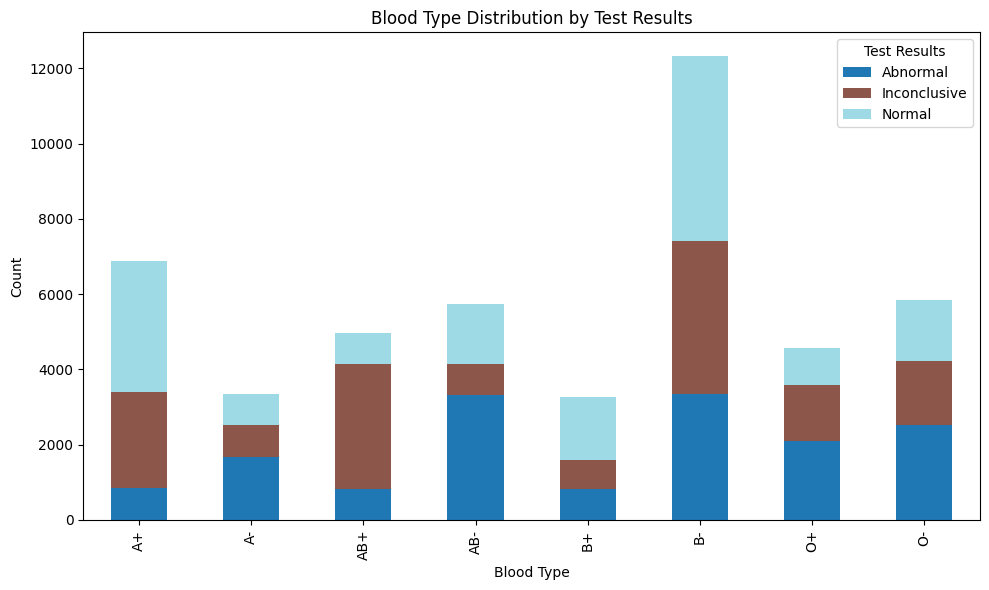

In [47]:
# Create crosstab of Blood Type vs Test Results
crosstab = pd.crosstab(df['Blood Type'], df['Test Results'])

# Display the crosstab
print("\nCrosstab of Blood Type vs Test Results:")
print(crosstab)

# Visualize as a stacked bar chart
crosstab.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='tab20')
plt.title('Blood Type Distribution by Test Results')
plt.xlabel('Blood Type')
plt.ylabel('Count')
plt.legend(title='Test Results')
plt.tight_layout()
plt.show()

In [48]:
(df.isnull().sum()/df.shape[0])*100

,0
ID,0.000
Age,0.000
Gender,0.000
Blood Type,6.130
Medical Condition,0.000
Doctor,1.608
Hospital,1.918
Insurance Provider,0.586
Billing Amount,1.448
Admission Type,0.362


In [49]:
df = df.drop(['ID'], axis=1)

In [50]:
duplicates = df.duplicated()
print(f"Number of duplicate rows: {duplicates.sum()}")

Number of duplicate rows: 0


In [51]:
missing_rows = df[df.isnull().any(axis=1)]
print("Rows with missing values:")
print(missing_rows)

Streaming output truncated to the last 5000 lines.
44841              44  
44842              18  
44843              15  
44844              40  
44845              85  
44846              74  
44847              12  
44848              36  
44849              47  
44850              47  
44851              70  
44852               6  
44853              23  
44854              49  
44855              44  
44856              81  
44857              24  
44858              18  
44859              94  
44860              14  
44861              33  
44862               2  
44863              98  
44864              33  
44865               6  
44866              13  
44867              11  
44868              67  
44869               2  
44870              22  
44871              58  
44874              43  
44875              78  
44876              64  
44877              68  
44878              17  
44879              22  
44880             100  
44881              53  
44882        

In [52]:
print("Percentage of missing values per column:")
print((df.isnull().mean() * 100).round(2))

Percentage of missing values per column:
Age                    0.00
Gender                 0.00
Blood Type             6.13
Medical Condition      0.00
Doctor                 1.61
Hospital               1.92
Insurance Provider     0.59
Billing Amount         1.45
Admission Type         0.36
Medication             0.00
Test Results           0.00
Inferred Gender       96.32
Length of Stay         0.00
dtype: float64


In [53]:
df.head()

,Age,Gender,Blood Type,Medical Condition,Doctor,Hospital,Insurance Provider,Billing Amount,Admission Type,Medication,Test Results,Inferred Gender,Length of Stay
0,27,Male,O-,Asthma,Mark Hartman Jr.,Sons and Miller,Cigna,26259.80554,Elective,Ibuprofen,Normal,Male,73
1,68,Female,O-,Cancer,Angela Contreras,White-White,Cigna,14713.87317,Elective,Ibuprofen,Inconclusive,None,1
2,21,Female,A+,Hypertension,David Ruiz,Group Middleton,Medicare,51314.88104,Emergency,Paracetamol,Normal,None,72
3,91,Male,AB-,Diabetes,Jenny Griffith,Morris-Arellano,Blue Cross,89727.93157,Urgent,Ibuprofen,Abnormal,None,20
4,52,Female,A+,Diabetes,Cynthia Scott,Williams-Davis,Blue Cross,20155.22684,Emergency,Penicillin,Abnormal,None,42


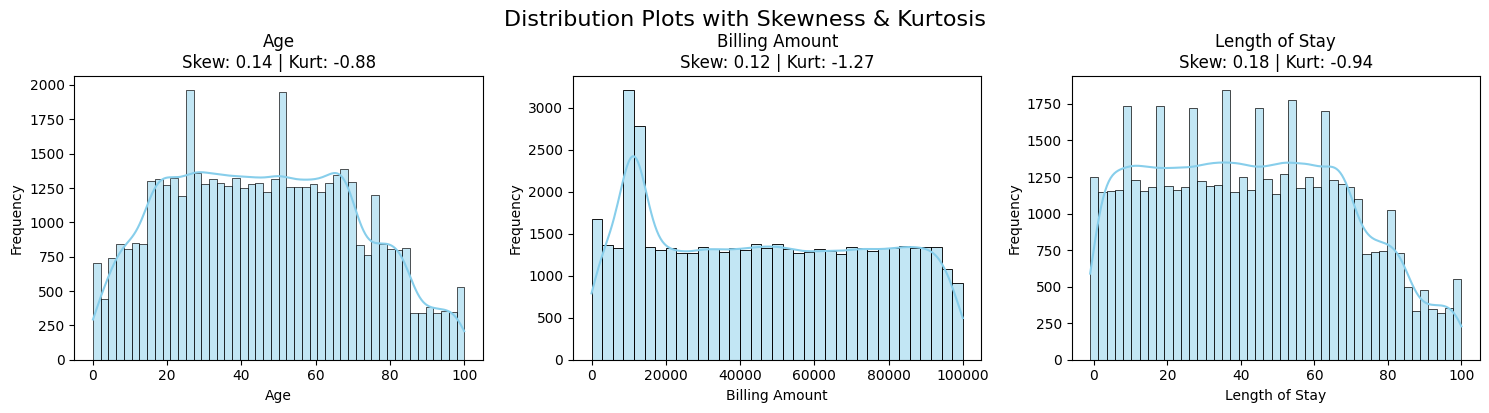

In [54]:
from scipy.stats import skew, kurtosis
import numpy as np

# Get all numeric columns
numeric_cols = df.select_dtypes(include='number').columns.tolist()

# Set number of columns in the grid
n_cols = 3
n_rows = int(np.ceil(len(numeric_cols) / n_cols))

# Set figure size
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*5, n_rows*4))
axes = axes.flatten()  # Flatten in case of single row

# Plot each numeric column
for i, col in enumerate(numeric_cols):
    sns.histplot(df[col], kde=True, ax=axes[i], color='skyblue')
    axes[i].set_title(f'{col}\nSkew: {skew(df[col].dropna()):.2f} | Kurt: {kurtosis(df[col].dropna()):.2f}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')

# Remove any extra subplots (if columns < grid size)
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.suptitle('Distribution Plots with Skewness & Kurtosis', fontsize=16, y=1.02)
plt.show()

In [55]:
import numpy as np
import pandas as pd

def has_outliers_iqr(data):
    try:
        clean_data = pd.to_numeric(data.dropna(), errors='coerce')
        q1 = np.percentile(clean_data, 25)
        q3 = np.percentile(clean_data, 75)
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        return ((clean_data < lower_bound) | (clean_data > upper_bound)).any()
    except:
        # If column can't be converted to numeric, skip it
        return False

# Check all columns
for col in df.columns:
    if has_outliers_iqr(df[col]):
        print(f"✅ Outliers detected in column: '{col}'")
    else:
        print(f"✅ No outliers in column: '{col}'")



✅ No outliers in column: 'Age'
✅ No outliers in column: 'Gender'
✅ No outliers in column: 'Blood Type'
✅ No outliers in column: 'Medical Condition'
✅ No outliers in column: 'Doctor'
✅ No outliers in column: 'Hospital'
✅ No outliers in column: 'Insurance Provider'
✅ No outliers in column: 'Billing Amount'
✅ No outliers in column: 'Admission Type'
✅ No outliers in column: 'Medication'
✅ No outliers in column: 'Test Results'
✅ No outliers in column: 'Inferred Gender'
✅ No outliers in column: 'Length of Stay'


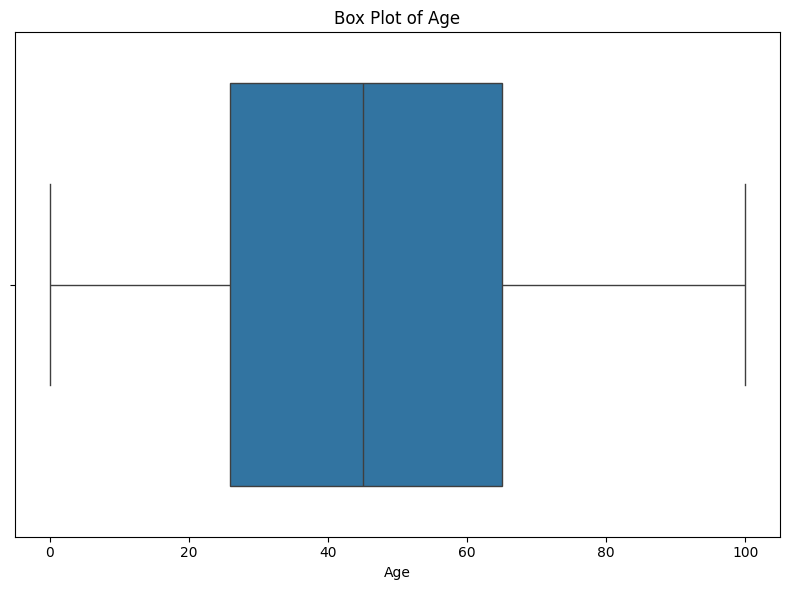

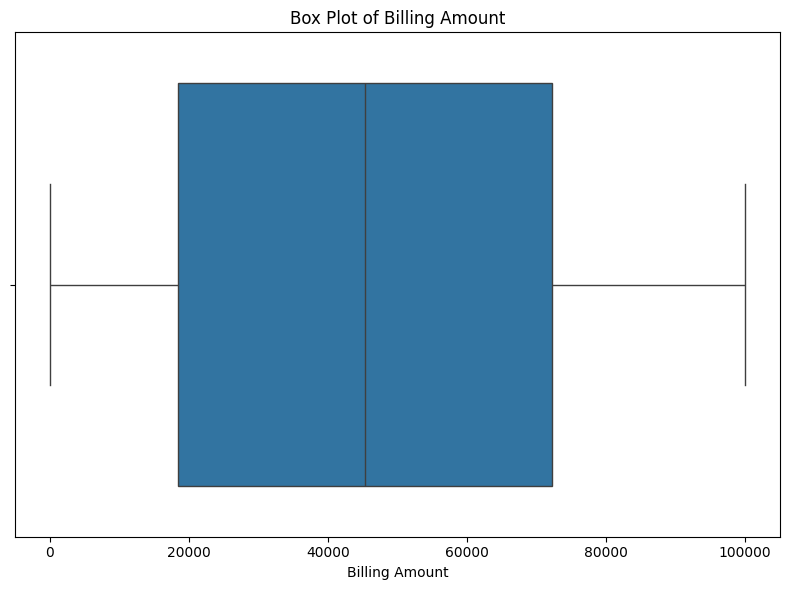

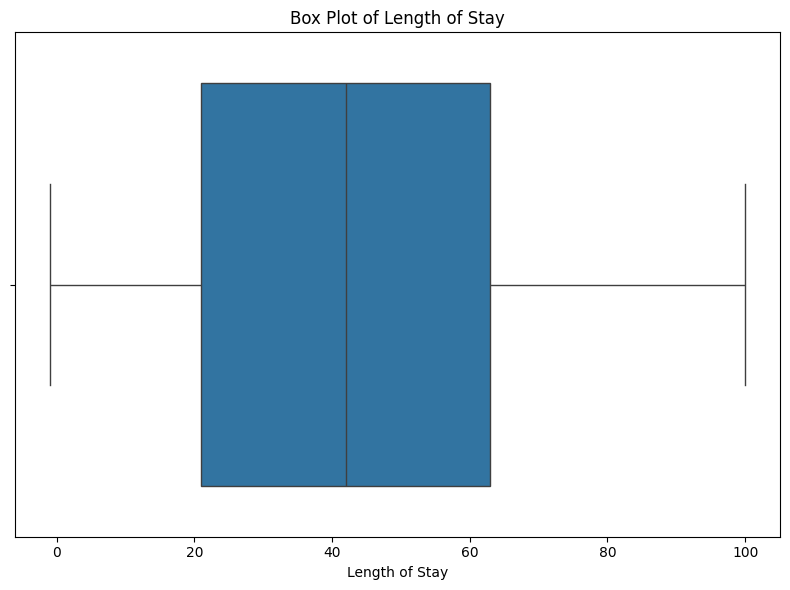

In [56]:
# Ensure numerical_cols is defined
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns

# Box plot for each numerical column
for col in numerical_cols:
    plt.figure(figsize=(8, 6))
    sns.boxplot(x=df[col])
    plt.title(f'Box Plot of {col}')
    plt.xlabel(col)
    plt.tight_layout()
    plt.show()


In [57]:
# Check unique values in object columns
for col in df.select_dtypes(include='object'):
    print(f"{col}: {df[col].unique()}\n")

# Check for invalid age
print(df[df['Age'] < 0])

# Check for missing or odd values in Billing Amount
print(df['Billing Amount'].describe())


Gender: ['Male' 'Female']

Blood Type: ['O-' 'A+' 'AB-' 'B-' 'O+' 'A-' 'AB+' 'B+' nan]

Medical Condition: ['Asthma' 'Cancer' 'Hypertension' 'Diabetes' 'Obesity' 'Arthritis']

Doctor: ['Mark Hartman Jr.' 'Angela Contreras' 'David Ruiz' 'Jenny Griffith'
 'Cynthia Scott' 'Julie Ramirez' 'Theresa Freeman' 'Connie Boyd'
 'Rose Zuniga' 'Travis Parsons' 'John Summers' 'Erika Jackson'
 'Patrick Burns' nan 'Cameron Young' 'Kyle Patterson' 'Patricia Colon'
 'Kelly Murphy' 'Brian Walton' 'Daniel Ferguson' 'Kayla Davis'
 'Heather Garcia' 'Kari Moore' 'Brandy Mitchell' 'Amanda Garcia'
 'Heather Smith' 'Stephen Carr' 'Lonnie Morgan' 'Wendy Davis'
 'James Ellis' 'Ryan Ross' 'Emily Patterson' 'Brent Smith' 'Emma Allison'
 'Matthew Carter' 'Miguel Parker' 'Julia Cox' 'Crystal Chavez'
 'Jason Price' 'Christina Hammond' 'William Hess' 'Katherine Brown'
 'Stephanie Kramer' 'Gregory Smith' 'Christine Johnson' 'Vicki Nguyen'
 'Stephanie Clements' 'Kayla Powers' 'Thomas Bruce' 'Laura Myers'
 'Lisa Edwards' 

In [58]:
print(f"Number of Billing Amount values below 0: {(df['Billing Amount'] < 0).sum()}")

Number of Billing Amount values below 0: 0


In [59]:
df[df['Billing Amount'] < 0].head()

,Age,Gender,Blood Type,Medical Condition,Doctor,Hospital,Insurance Provider,Billing Amount,Admission Type,Medication,Test Results,Inferred Gender,Length of Stay


In [60]:
negative_billing = df[df['Billing Amount'] < 0]['Billing Amount']
mean_negative = negative_billing.mean()
min_negative = negative_billing.min()
max_negative = negative_billing.max()

print(f"Mean of negative billing amounts: {mean_negative}")
print(f"Min of negative billing amounts: {min_negative}")
print(f"Max of negative billing amounts: {max_negative}")


Mean of negative billing amounts: nan
Min of negative billing amounts: nan
Max of negative billing amounts: nan


In [61]:
# Convert negative billing amounts to positive
df['Billing Amount'] = df['Billing Amount'].abs()

In [62]:
# Check for missing or odd values in Billing Amount
print(df['Billing Amount'].describe())

count    49276.000000
mean     46408.828704
std      29367.976855
min          1.056660
25%      18508.013005
50%      45315.314410
75%      72159.877597
max      99998.187690
Name: Billing Amount, dtype: float64


In [63]:
print(df.head())
df.shape

   Age  Gender Blood Type Medical Condition            Doctor  \
0   27    Male         O-            Asthma  Mark Hartman Jr.   
1   68  Female         O-            Cancer  Angela Contreras   
2   21  Female         A+      Hypertension        David Ruiz   
3   91    Male        AB-          Diabetes    Jenny Griffith   
4   52  Female         A+          Diabetes     Cynthia Scott   

          Hospital Insurance Provider  Billing Amount Admission Type  \
0  Sons and Miller              Cigna     26259.80554       Elective   
1      White-White              Cigna     14713.87317       Elective   
2  Group Middleton           Medicare     51314.88104      Emergency   
3  Morris-Arellano         Blue Cross     89727.93157         Urgent   
4   Williams-Davis         Blue Cross     20155.22684      Emergency   

    Medication  Test Results Inferred Gender  Length of Stay  
0    Ibuprofen        Normal            Male              73  
1    Ibuprofen  Inconclusive            None      

(50000, 13)

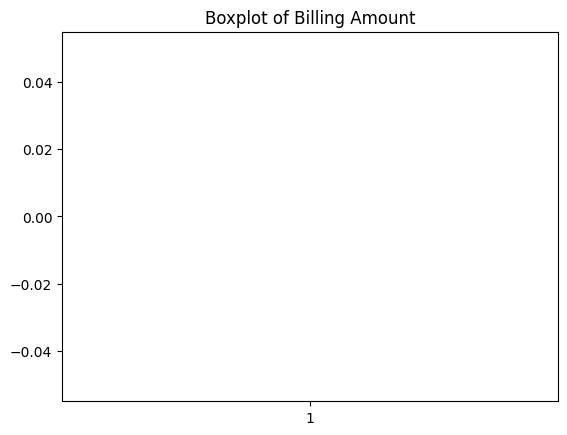

In [64]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'df' is your DataFrame
plt.boxplot(df['Billing Amount'])
plt.title('Boxplot of Billing Amount')
plt.show()

In [65]:
count_below_50 = (df['Billing Amount'] < 50).sum()
print(f"Number of Billing Amount values below 50: {count_below_50}")

count_below_500 = (df['Billing Amount'] < 500).sum()
print(f"Number of Billing Amount values below 500: {count_below_500}")

count_below_10000 = (df['Billing Amount'] < 10000).sum()
print(f"Number of Billing Amount values below 10000: {count_below_10000}")


Number of Billing Amount values below 50: 28
Number of Billing Amount values below 500: 265
Number of Billing Amount values below 10000: 4952


In [66]:
# Calculate median
median = df['Billing Amount'].median()

# Calculate Median Absolute Deviation (MAD)
mad = np.median(np.abs(df['Billing Amount'] - median))

# Calculate Modified Z-Score
# 0.6745 is a constant to make MAD comparable to standard deviation in a normal distribution
modified_z_scores = 0.6745 * (df['Billing Amount'] - median) / mad

# Identify outliers (threshold of 3.5 is common for Modified Z-Score)
outliers = df[np.abs(modified_z_scores) > 3.5]

# Print the number of outliers and their values
print(f"Number of outliers: {len(outliers)}")
print(outliers[['Billing Amount']])

Number of outliers: 0
Empty DataFrame
Columns: [Billing Amount]
Index: []


Number of values below threshold (100): 51
       Billing Amount
455          31.50846
1572         98.14629
4510         39.45101
4922         21.59944
5395         43.53327
5630         94.87058
5877         16.41399
6823         78.04157
7634         60.73665
8043         69.09071
9873         63.42179
9971         68.36662
10040        64.73453
12058        73.44704
12847        66.68017
13313        40.11341
13324        85.84105
14169        97.24199
15640        20.89947
16186        39.62943
16301        29.78738
17213        42.29893
18475        10.96654
19305        54.20976
20262        85.25296
21344         5.32405
23007        59.05143
23476         6.09366
25436        87.71243
25491        48.03247
26329        67.46065
27518        75.00696
29028        32.63676
30928        80.39337
31035        11.25076
32001        18.01336
32215        45.72781
34068        76.41972
35427         6.20763
39514        24.31306
39701        57.74076
41435        10.57258
42014      

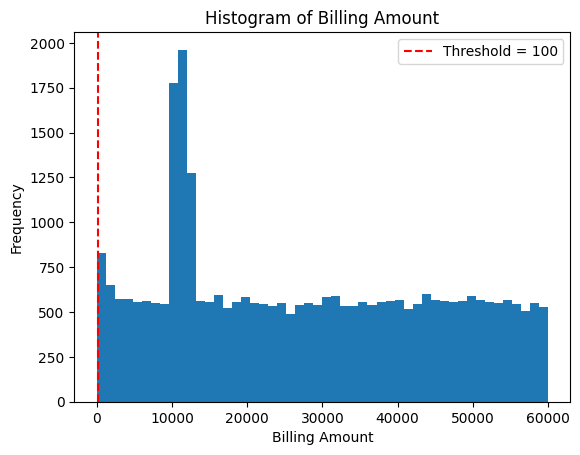

In [67]:

# Set a domain-specific threshold (e.g., 100 as a plausible minimum billing amount)
threshold = 100
potential_outliers = df[df['Billing Amount'] < threshold]

# Print number and values of potential outliers
print(f"Number of values below threshold ({threshold}): {len(potential_outliers)}")
print(potential_outliers[['Billing Amount']])

# Visualize with a histogram
plt.hist(df['Billing Amount'], bins=50, range=(0, 60000))
plt.axvline(x=threshold, color='r', linestyle='--', label=f'Threshold = {threshold}')
plt.title('Histogram of Billing Amount')
plt.xlabel('Billing Amount')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [68]:
df[df['Billing Amount'] < 1000]

,Age,Gender,Blood Type,Medical Condition,Doctor,Hospital,Insurance Provider,Billing Amount,Admission Type,Medication,Test Results,Inferred Gender,Length of Stay
54,45,Male,AB+,Arthritis,Crystal Chavez,Serrano-Dixon,Aetna,786.34574,NaN,Ibuprofen,Inconclusive,None,62
95,9,Female,NaN,Asthma,NaN,Nunez-Humphrey,Blue Cross,140.43821,Urgent,Lipitor,Abnormal,None,56
106,12,Female,AB+,Hypertension,Jacob Rich,PLC Young,Aetna,440.26124,NaN,Aspirin,Inconclusive,None,57
134,46,Male,B+,Hypertension,Julie Finley,Gardner-Miller,Blue Cross,966.85887,NaN,Paracetamol,Normal,None,82
211,32,Female,A+,Obesity,Justin Kim,Hart Ltd,Aetna,169.77407,NaN,Ibuprofen,Inconclusive,None,14
342,79,Male,AB-,Arthritis,NaN,Houston PLC,Cigna,443.90186,Urgent,Aspirin,Abnormal,None,5
359,29,Female,AB+,Asthma,Jacob Rich,Hammond Ltd,Aetna,709.54893,Urgent,Ibuprofen,Inconclusive,None,79
455,8,Female,O-,Diabetes,NaN,Houston PLC,Aetna,31.50846,Elective,Penicillin,Inconclusive,None,62
535,39,Female,O+,Obesity,NaN,Sons Rich and,Aetna,290.76089,Urgent,Lipitor,Inconclusive,None,33
1029,71,Male,A-,Arthritis,Mary Moss,Clark-Mayo,NaN,761.69777,Urgent,Aspirin,Abnormal,None,44


In [69]:
print(df['Billing Amount'].describe())

count    49276.000000
mean     46408.828704
std      29367.976855
min          1.056660
25%      18508.013005
50%      45315.314410
75%      72159.877597
max      99998.187690
Name: Billing Amount, dtype: float64


In [70]:
# # Cell: Impute Low Amounts Function and Usage with Dataset
# def impute_low_amounts(values, threshold=500, median_valid=None):
#     # If median_valid is not provided, calculate it from values above threshold
#     if median_valid is None:
#         median_valid = values[values >= threshold].median()
#         if pd.isna(median_valid):
#             median_valid = values.median()  # Fallback to overall median if no valid values

#     # Impute values below threshold with the median
#     def impute_single_value(x):
#         return median_valid if x < threshold else x

#     return values.apply(impute_single_value)

# # Apply to the dataset
# print("Original Billing Amount data:")
# print(df['Billing Amount'].describe())

# # Apply the imputation to the dataset
# df['Billing Amount'] = impute_low_amounts(df['Billing Amount'])

# # Verify the results
# print("\nImputed Billing Amount data:")
# print(df['Billing Amount'].describe())

# # Verify the median used
# median_used = df['Billing Amount'][df['Billing Amount'] >= threshold].median()
# print(f"\nMedian used for imputation: ${median_used}")

In [71]:
print(df['Billing Amount'].describe())

count    49276.000000
mean     46408.828704
std      29367.976855
min          1.056660
25%      18508.013005
50%      45315.314410
75%      72159.877597
max      99998.187690
Name: Billing Amount, dtype: float64


In [72]:
df[df['Billing Amount'] < 100]

,Age,Gender,Blood Type,Medical Condition,Doctor,Hospital,Insurance Provider,Billing Amount,Admission Type,Medication,Test Results,Inferred Gender,Length of Stay
455,8,Female,O-,Diabetes,NaN,Houston PLC,Aetna,31.50846,Elective,Penicillin,Inconclusive,None,62
1572,31,Female,O+,Asthma,Brian Walton,"Gates Brown, and Stuart",Blue Cross,98.14629,Urgent,Ibuprofen,Inconclusive,None,78
4510,30,Female,B-,Asthma,Erin Henderson MD,"Powell Robinson and Valdez,",Cigna,39.45101,Urgent,Paracetamol,Abnormal,None,22
4922,55,Male,O-,Asthma,Vanessa Newton,Walton-Meyer,Cigna,21.59944,Urgent,Paracetamol,Inconclusive,None,12
5395,66,Male,O+,Cancer,Stephanie Clements,Cline-Williams,Aetna,43.53327,Emergency,Aspirin,Inconclusive,None,12
5630,51,Male,A+,Diabetes,Angela Contreras,Rivera-Gutierrez,Aetna,94.87058,Elective,Paracetamol,Inconclusive,None,75
5877,49,Female,O-,Hypertension,John Duncan,Kim Inc,Cigna,16.41399,Emergency,Penicillin,Abnormal,None,64
6823,23,Male,AB-,Asthma,Stephanie Kramer,Kim Inc,Blue Cross,78.04157,Urgent,Aspirin,Abnormal,None,62
7634,31,Male,B-,Cancer,Timothy Baker,Rivera-Gutierrez,Aetna,60.73665,Elective,Ibuprofen,Inconclusive,None,75
8043,19,Male,AB-,Hypertension,Erika Jackson,"Torres, and Harrison Jones",Blue Cross,69.09071,Urgent,Penicillin,Abnormal,None,20


In [73]:
# prompt: display counts of records with billing amounts from: ranges from 1 to 100, 101 to 500, 501 to 1000, 1001 to 5000, 5001 to 10000, 10001 to max

# Assuming 'df' is your DataFrame after all the preprocessing steps

# Define the billing amount ranges
bins = [1, 100, 500, 1000, 5000, 10000, float('inf')]
labels = ['1-100', '101-500', '501-1000', '1001-5000', '5001-10000', '10001+']

# Cut the 'Billing Amount' column into these ranges
print(pd.cut(df['Billing Amount'], bins=bins, labels=labels, right=False).value_counts())

# Display the counts for each range
# print(df['Billing_Range'].value_counts())


Billing Amount
10001+        44324
1001-5000      2254
5001-10000     2230
101-500         214
501-1000        203
1-100            51
Name: count, dtype: int64


In [74]:
df[df['Billing Amount'] < 50]

,Age,Gender,Blood Type,Medical Condition,Doctor,Hospital,Insurance Provider,Billing Amount,Admission Type,Medication,Test Results,Inferred Gender,Length of Stay
455,8,Female,O-,Diabetes,NaN,Houston PLC,Aetna,31.50846,Elective,Penicillin,Inconclusive,None,62
4510,30,Female,B-,Asthma,Erin Henderson MD,"Powell Robinson and Valdez,",Cigna,39.45101,Urgent,Paracetamol,Abnormal,None,22
4922,55,Male,O-,Asthma,Vanessa Newton,Walton-Meyer,Cigna,21.59944,Urgent,Paracetamol,Inconclusive,None,12
5395,66,Male,O+,Cancer,Stephanie Clements,Cline-Williams,Aetna,43.53327,Emergency,Aspirin,Inconclusive,None,12
5877,49,Female,O-,Hypertension,John Duncan,Kim Inc,Cigna,16.41399,Emergency,Penicillin,Abnormal,None,64
13313,29,Female,AB+,Obesity,Michael Baker,Group Middleton,Medicare,40.11341,Emergency,Lipitor,Normal,None,77
15640,34,Male,O+,Diabetes,Wendy Glenn,Rivera-Gutierrez,Blue Cross,20.89947,Urgent,Penicillin,Abnormal,None,66
16186,30,Male,O-,Asthma,Christopher Guerra,White-White,Cigna,39.62943,Urgent,Penicillin,Abnormal,None,22
16301,48,Male,B-,Obesity,Steven James,Schaefer-Porter,Aetna,29.78738,Urgent,Penicillin,Inconclusive,None,57
17213,59,Female,A+,Hypertension,Mark Hartman Jr.,Hall-Bentley,Cigna,42.29893,Urgent,Aspirin,Normal,None,15


In [75]:
df.head()

,Age,Gender,Blood Type,Medical Condition,Doctor,Hospital,Insurance Provider,Billing Amount,Admission Type,Medication,Test Results,Inferred Gender,Length of Stay
0,27,Male,O-,Asthma,Mark Hartman Jr.,Sons and Miller,Cigna,26259.80554,Elective,Ibuprofen,Normal,Male,73
1,68,Female,O-,Cancer,Angela Contreras,White-White,Cigna,14713.87317,Elective,Ibuprofen,Inconclusive,None,1
2,21,Female,A+,Hypertension,David Ruiz,Group Middleton,Medicare,51314.88104,Emergency,Paracetamol,Normal,None,72
3,91,Male,AB-,Diabetes,Jenny Griffith,Morris-Arellano,Blue Cross,89727.93157,Urgent,Ibuprofen,Abnormal,None,20
4,52,Female,A+,Diabetes,Cynthia Scott,Williams-Davis,Blue Cross,20155.22684,Emergency,Penicillin,Abnormal,None,42


In [76]:
# Calculate the number of records where 'Gender' is 'Unknown'
unknown_gender_count = df[df['Inferred Gender'] == 'Unknown'].shape[0]

print(f"Number of records with 'Unknown' gender: {unknown_gender_count}")

# You can also check the value counts for the 'Gender' column to see all categories and their counts
print("\nValue counts for 'Gender' column:")
print(df['Gender'].value_counts())

Number of records with 'Unknown' gender: 0

Value counts for 'Gender' column:
Gender
Female    28294
Male      21706
Name: count, dtype: int64


In [77]:
# # Convert 'Date of Admission' and 'Discharge Date' to datetime objects
# df['Date of Admission'] = pd.to_datetime(df['Date of Admission'], dayfirst=True)
# df['Discharge Date'] = pd.to_datetime(df['Discharge Date'], dayfirst=True)


# # Calculate 'Stay Days'
# # Subtracting the dates results in a Timedelta object, .dt.days extracts the number of days
# df['Stay Days'] = (df['Discharge Date'] - df['Date of Admission']).dt.days

# # Print the first few rows with the new column
# print(df[['Date of Admission', 'Discharge Date', 'Stay Days']].head())

# # Check descriptive statistics of the new column
# print("\nDescription of Stay Days:")
# print(df['Stay Days'].describe())

# # Check for any negative stay days (might indicate data entry errors)
# negative_stay_days = df[df['Stay Days'] < 0]
# print(f"\nNumber of records with negative Stay Days: {len(negative_stay_days)}")
# # negative_stay_days[['Date of Admission', 'Discharge Date', 'Stay Days']].head()


In [78]:
print(df['Admission Type'].unique())


['Elective' 'Emergency' 'Urgent' nan]


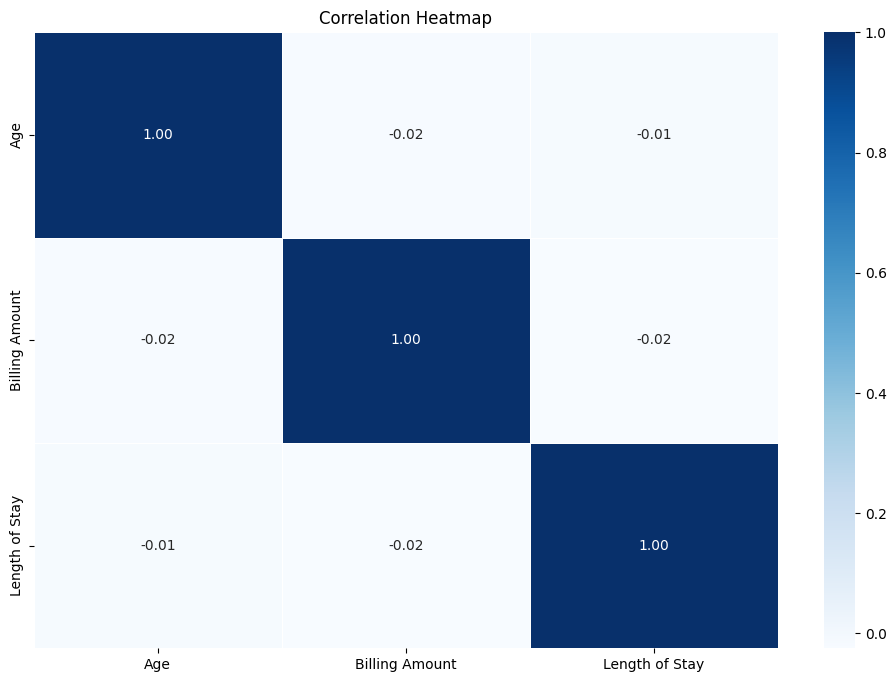

In [79]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute the correlation matrix
corr = df.corr(numeric_only=True)

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=True, cmap='Blues', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

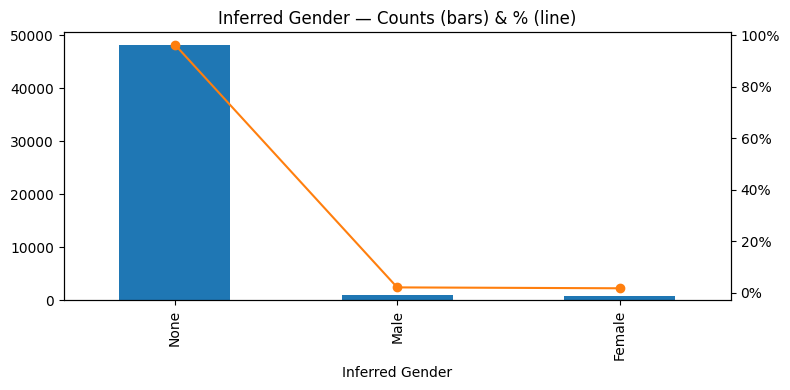

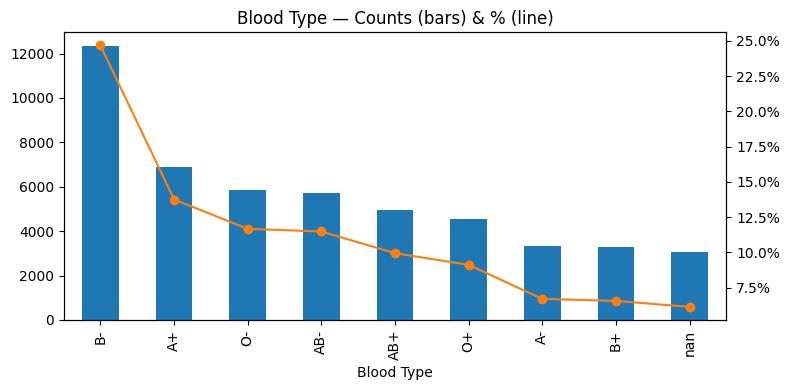

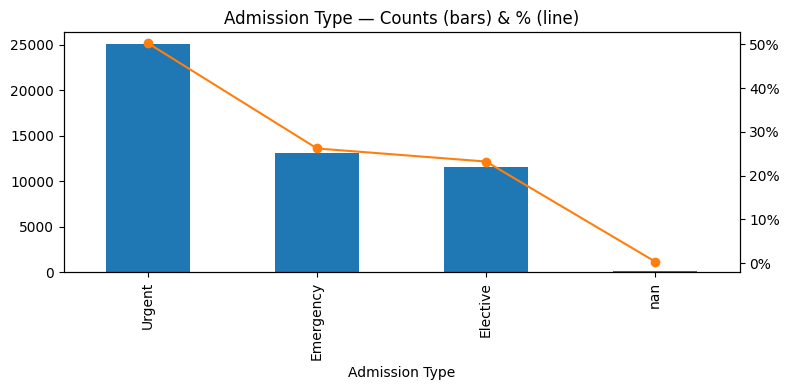

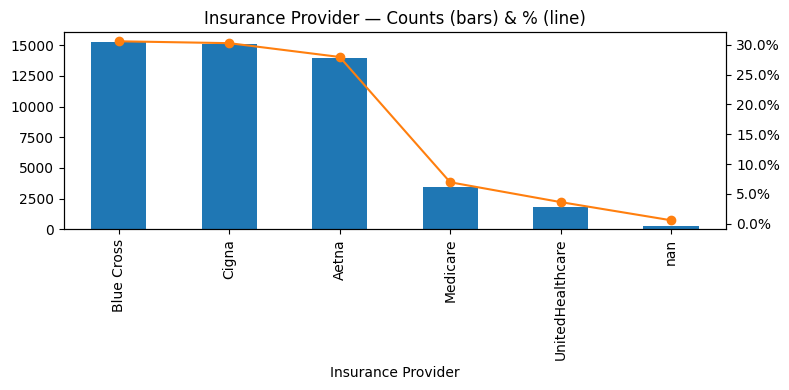

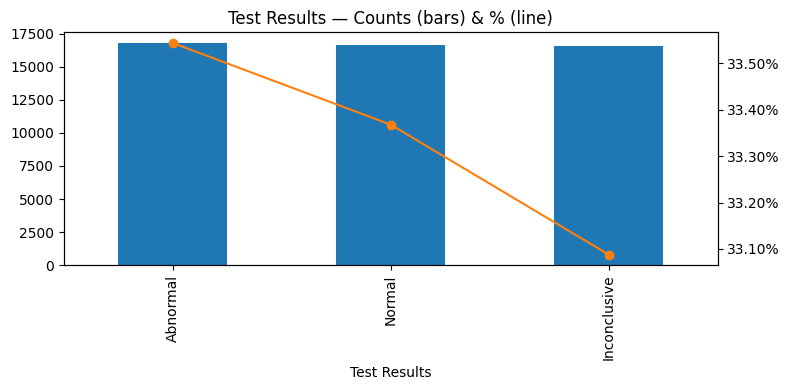

In [80]:
import matplotlib.ticker as mtick

def bar_pct(col, figsize=(8,4)):
    vc = df[col].value_counts(dropna=False)
    pct = vc / vc.sum()
    fig, ax = plt.subplots(figsize=figsize)
    vc.plot.bar(ax=ax)
    ax2 = ax.twinx()
    (pct*100).plot.line(color='C1', marker='o', ax=ax2)
    ax2.yaxis.set_major_formatter(mtick.PercentFormatter())
    ax.set_title(f"{col} — Counts (bars) & % (line)")
    ax.set_xlabel(col)
    fig.tight_layout()
    plt.show()

for cat in ['Inferred Gender','Blood Type','Admission Type','Insurance Provider','Test Results']:
    bar_pct(cat)

#Normalization

In [81]:
# # Check unique values in 'Date of Admission'
# unique_values = df['Date of Admission'].unique()
# print("Unique values in 'Date of Admission':", unique_values)

# # Find the minimum and maximum values
# min_date = df['Date of Admission'].min()
# max_date = df['Date of Admission'].max()
# print("Minimum date of admission:", min_date)
# print("Maximum date of admission:", max_date)

In [82]:
# df['Date of Admission'] = pd.to_datetime(df['Date of Admission'])

# # Convert to days since earliest admission
# min_date = df['Date of Admission'].min()
# df['Date of Admission'] = (df['Date of Admission'] - min_date).dt.days

# # Normalize using MinMaxScaler
# scaler = MinMaxScaler()
# df['Date of Admission'] = scaler.fit_transform(df[['Date of Admission']])

# # Preview result
# print(df[['Date of Admission']].head())


In [83]:
# unique_values = df['Billing Amount'].unique()
# min_value = df['Billing Amount'].min()
# max_value = df['Billing Amount'].max()
# print("Unique values in 'Billing Amount':", unique_values)
# print("Minimum value in 'Billing Amount':", min_value)
# print("Maximum value in 'Billing Amount':", max_value)

In [84]:
# df['Billing Amount'] = scaler.fit_transform(df[['Billing Amount']])
# df.head()

In [85]:
# unique_values = df['Room Number'].unique()
# min_value = df['Room Number'].min()
# max_value = df['Room Number'].max()
# print("Unique values in 'Room Number':", unique_values)
# print("Minimum value in 'Room Number':", min_value)
# print("Maximum value in 'Room Number':", max_value)

In [86]:
# unique_values = df['Discharge Date'].unique()
# min_value = df['Discharge Date'].min()
# max_value = df['Discharge Date'].max()
# print("Unique values in 'Discharge Date':", unique_values)
# print("Minimum value in 'Discharge Date':", min_value)
# print("Maximum value in 'Discharge Date':", max_value)

In [87]:
# # Convert 'Discharge Date' to datetime if it's not already in datetime format
# df['Discharge Date'] = pd.to_datetime(df['Discharge Date'])

# # Convert 'Discharge Date' to days since the earliest discharge date
# min_date = df['Discharge Date'].min()
# df['Discharge Date'] = (df['Discharge Date'] - min_date).dt.days

# df['Discharge Date'] = scaler.fit_transform(df[['Discharge Date']])
# df.head()

In [88]:
# df = df.drop('Admission Date', axis=1)
# print(df.columns)

In [89]:
# unique_values = df['Test Results'].unique()
# min_value = df['Test Results'].min()
# max_value = df['Test Results'].max()
# print("Unique values in 'Test Results':", unique_values)
# print("Minimum value in 'Test Results':", min_value)
# print("Maximum value in 'Test Results':", max_value)

In [90]:
# unique_values = df['Doctor_Encoded'].unique()
# min_value = df['Doctor_Encoded'].min()
# max_value = df['Doctor_Encoded'].max()
# print("Unique values in 'Doctor_Encoded':", unique_values)
# print("Minimum value in 'Doctor_Encoded':", min_value)
# print("Maximum value in 'Doctor_Encoded':", max_value)

In [91]:
# top_counts = df['Doctor_Encoded'].value_counts().nlargest(20)
# plt.figure(figsize=(12, 6))
# top_counts.plot(kind='bar', color='orange')
# plt.title("Top 20 Most Frequent 'Doctor_Encoded' Values")
# plt.xlabel('Doctor_Encoded Value')
# plt.ylabel('Count')
# plt.show()

In [92]:
# unique_values = df['Hospital_Encoded'].unique()
# min_value = df['Hospital_Encoded'].min()
# max_value = df['Hospital_Encoded'].max()
# print("Unique values in 'Hospital_Encoded':", unique_values)
# print("Minimum value in 'Hospital_Encoded':", min_value)
# print("Maximum value in 'Hospital_Encoded':", max_value)

In [93]:
# top_counts = df['Hospital_Encoded'].value_counts().nlargest(20)
# plt.figure(figsize=(12, 6))
# top_counts.plot(kind='bar', color='orange')
# plt.title("Top 20 Most Frequent 'Doctor_Encoded' Values")
# plt.xlabel('Doctor_Encoded Value')
# plt.ylabel('Count')
# plt.show()

In [94]:
# # Normalize 'Doctor_Encoded'
# df['Doctor_Encoded'] = scaler.fit_transform(df[['Doctor_Encoded']])

# # Normalize 'Hospital_Encoded'
# df['Hospital_Encoded'] = scaler.fit_transform(df[['Hospital_Encoded']])
# df.head()

In [95]:
# df['Stay Days'] = scaler.fit_transform(df[['Stay Days']])
# df['Insurance Provider_Self-Pay'] = df['Insurance Provider_Self-Pay'].astype(int)

# df.head()


In [96]:
# plt.figure(figsize=(30, 12))
# sns.heatmap(df.corr(), annot=True, cmap='Blues', fmt=".2f", linewidths=0.5)
# plt.title('Correlation Heatmap After Normalization/Encoding')
# plt.show()

In [97]:
# from scipy.stats import skew, kurtosis
# import numpy as np

# # Get all numeric columns
# numeric_cols = df.select_dtypes(include='number').columns.tolist()

# # Set number of columns in the grid
# n_cols = 3
# n_rows = int(np.ceil(len(numeric_cols) / n_cols))

# # Set figure size
# fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*5, n_rows*4))
# axes = axes.flatten()  # Flatten in case of single row

# # Plot each numeric column
# for i, col in enumerate(numeric_cols):
#     sns.histplot(df[col], kde=True, ax=axes[i], color='skyblue')
#     axes[i].set_title(f'{col}\nSkew: {skew(df[col].dropna()):.2f} | Kurt: {kurtosis(df[col].dropna()):.2f}')
#     axes[i].set_xlabel(col)
#     axes[i].set_ylabel('Frequency')

# # Remove any extra subplots (if columns < grid size)
# for j in range(i + 1, len(axes)):
#     fig.delaxes(axes[j])

# plt.tight_layout()
# plt.suptitle('Distribution Plots with Skewness & Kurtosis', fontsize=16, y=1.02)
# plt.show()

# Applying PCA

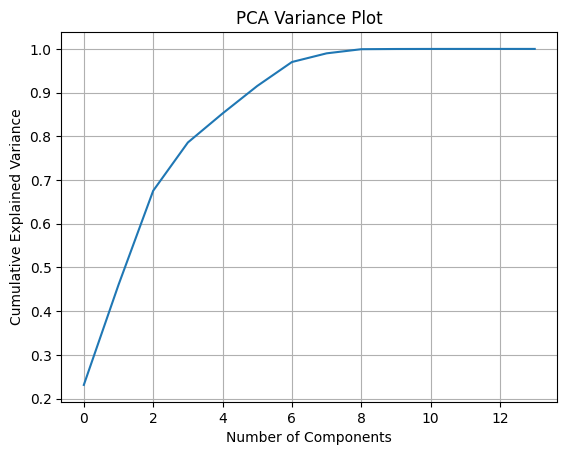

              precision    recall  f1-score   support

    Abnormal       0.79      0.81      0.80      3354
Inconclusive       0.65      0.67      0.66      3309
      Normal       0.73      0.68      0.71      3337

    accuracy                           0.72     10000
   macro avg       0.72      0.72      0.72     10000
weighted avg       0.72      0.72      0.72     10000

PCA components used: 7


In [98]:
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import numpy as np

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Step 1: Inspect explained variance
X_processed = preprocessor.fit_transform(X)
pca_inspect = PCA().fit(X_processed)

# Plot cumulative explained variance
plt.plot(np.cumsum(pca_inspect.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Variance Plot')
plt.grid(True)
plt.show()

# Step 2: Fit the model using PCA inside the pipeline
pca_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('pca', PCA(n_components=0.95)),  # keep components that explain 95% variance
    ('classifier', RandomForestClassifier(random_state=42))
])

# Train and evaluate
pca_pipeline.fit(X_train, y_train)
y_pred = pca_pipeline.predict(X_test)
print(classification_report(y_test, y_pred))

# Optional: Check how many components were selected
print("PCA components used:", pca_pipeline.named_steps['pca'].n_components_)


# Naïve Bayes (Without PCA)

In [99]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Label encode the target
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# 80/10/10 split
X_train, X_temp, y_train, y_temp = train_test_split(X, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

# Create pipeline (replace StandardScaler with MinMaxScaler for MultinomialNB)
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

cat_cols = X.select_dtypes(include='object').columns.tolist()
num_cols = X.select_dtypes(include='number').columns.tolist()

preprocessor_nb = ColumnTransformer(transformers=[
    ('num', Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', MinMaxScaler())  # ✅ MultinomialNB needs non-negative inputs
    ]), num_cols),
    ('cat', Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ]), cat_cols)
])

# Define pipeline
nb_pipeline = Pipeline([
    ('preprocessor', preprocessor_nb),
    ('classifier', MultinomialNB())
])

# Train and evaluate
nb_pipeline.fit(X_train, y_train)
y_pred = nb_pipeline.predict(X_test)

print("Multinomial Naive Bayes (No PCA):")
print(classification_report(le.inverse_transform(y_test), le.inverse_transform(y_pred)))



Multinomial Naive Bayes (No PCA):
              precision    recall  f1-score   support

    Abnormal       0.82      0.85      0.83      1677
Inconclusive       0.78      0.77      0.78      1654
      Normal       0.82      0.81      0.81      1669

    accuracy                           0.81      5000
   macro avg       0.81      0.81      0.81      5000
weighted avg       0.81      0.81      0.81      5000



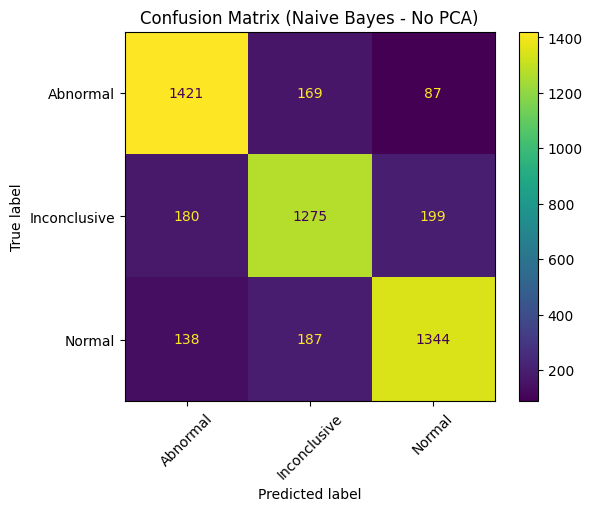

In [100]:
ConfusionMatrixDisplay.from_predictions(le.inverse_transform(y_test), le.inverse_transform(y_pred))
plt.title("Confusion Matrix (Naive Bayes - No PCA)")
plt.xticks(rotation=45)
plt.grid(False)
plt.show()



# Naïve Bayes + PCA

In [102]:
from sklearn.decomposition import PCA
from sklearn.naive_bayes import GaussianNB

# Define pipeline with PCA

nb_pca_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('pca', PCA(n_components=0.95)),
    ('classifier', GaussianNB())
])


# Train and evaluate
nb_pca_pipeline.fit(X_train, y_train)
y_pred_pca = nb_pca_pipeline.predict(X_test)

print("Multinomial Naive Bayes (With PCA):")
print(classification_report(le.inverse_transform(y_test), le.inverse_transform(y_pred_pca)))




Multinomial Naive Bayes (With PCA):
              precision    recall  f1-score   support

    Abnormal       0.80      0.71      0.75      1677
Inconclusive       0.61      0.64      0.62      1654
      Normal       0.63      0.66      0.64      1669

    accuracy                           0.67      5000
   macro avg       0.68      0.67      0.67      5000
weighted avg       0.68      0.67      0.67      5000



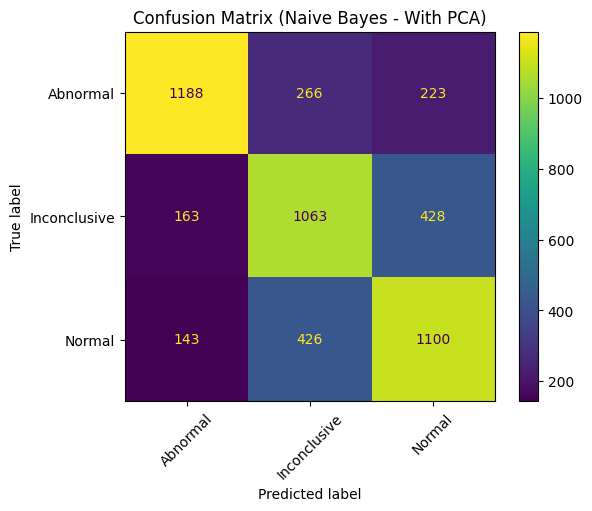

In [103]:
ConfusionMatrixDisplay.from_predictions(le.inverse_transform(y_test), le.inverse_transform(y_pred_pca))
plt.title("Confusion Matrix (Naive Bayes - With PCA)")
plt.xticks(rotation=45)
plt.grid(False)
plt.show()

#Ensemble Models (Without PCA)

## Random Forest

In [105]:
from sklearn.ensemble import RandomForestClassifier
# --- 1. Encode labels ---
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# --- 2. Split once into train (80%), temp (20%) ---
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42
)

# --- 3. Split temp into validation (10%) and test (10%) ---
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
)

# --- 4. Random Forest pipeline WITHOUT PCA ---
rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

rf_pipeline.fit(X_train, y_train)
y_pred = rf_pipeline.predict(X_test)


print("🔎 Random Forest WITHOUT PCA — Validation:")
y_val_pred = rf_pipeline.predict(X_val)
print(classification_report(le.inverse_transform(y_val), le.inverse_transform(y_val_pred)))

print("✅ Random Forest WITHOUT PCA — Test:")
y_test_pred = rf_pipeline.predict(X_test)
print(classification_report(le.inverse_transform(y_test), le.inverse_transform(y_test_pred)))

🔎 Random Forest WITHOUT PCA — Validation:
              precision    recall  f1-score   support

    Abnormal       0.87      0.83      0.85      1677
Inconclusive       0.78      0.81      0.79      1655
      Normal       0.84      0.84      0.84      1668

    accuracy                           0.83      5000
   macro avg       0.83      0.83      0.83      5000
weighted avg       0.83      0.83      0.83      5000

✅ Random Forest WITHOUT PCA — Test:
              precision    recall  f1-score   support

    Abnormal       0.85      0.81      0.83      1677
Inconclusive       0.76      0.80      0.78      1654
      Normal       0.85      0.84      0.84      1669

    accuracy                           0.82      5000
   macro avg       0.82      0.82      0.82      5000
weighted avg       0.82      0.82      0.82      5000



##XGBoost

In [106]:
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_encoded = le.fit_transform(y)  # converts to [0, 1, 2]

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42
)

# Step 3: Split remaining 20% into 10% validation, 10% test
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
)

xgb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42))
])

# Step 5: Fit on training set
xgb_pipeline.fit(X_train, y_train)


# Step 6: Evaluate on validation set
y_val_pred = xgb_pipeline.predict(X_val)
print("Validation Performance:")
print(classification_report(le.inverse_transform(y_val), le.inverse_transform(y_val_pred)))

# Step 7: Final test evaluation
y_test_pred = xgb_pipeline.predict(X_test)
print("Test Performance:")
print(classification_report(le.inverse_transform(y_test), le.inverse_transform(y_test_pred)))

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [21:21:09] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Validation Performance:
              precision    recall  f1-score   support

    Abnormal       0.88      0.87      0.88      1677
Inconclusive       0.84      0.85      0.84      1655
      Normal       0.89      0.89      0.89      1668

    accuracy                           0.87      5000
   macro avg       0.87      0.87      0.87      5000
weighted avg       0.87      0.87      0.87      5000

Test Performance:
              precision    recall  f1-score   support

    Abnormal       0.86      0.85      0.86      1677
Inconclusive       0.83      0.83      0.83      1654
      Normal       0.89      0.89      0.89      1669

    accuracy                           0.86      5000
   macro avg       0.86      0.86      0.86      5000
weighted avg       0.86      0.86      0.86      5000



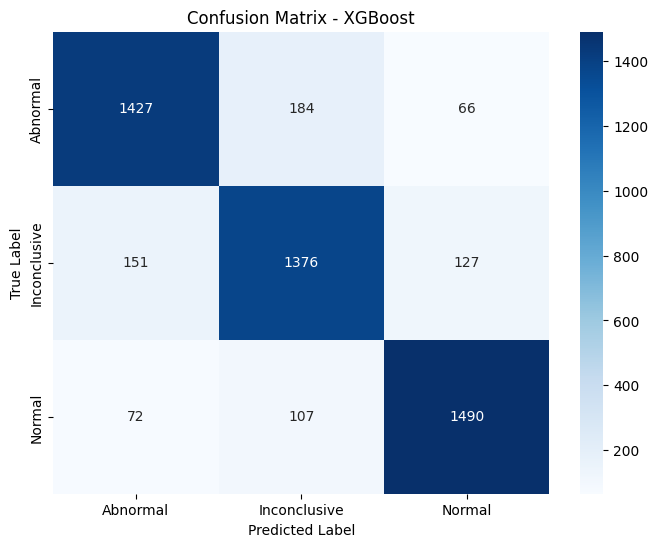

In [107]:
from sklearn.metrics import confusion_matrix

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_test_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix - XGBoost')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


#Ensemble Models (With PCA)

## Random Forest

In [109]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder

# --- 1. Encode labels ---
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# --- 2. Split once into train (80%), temp (20%) ---
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42
)

# --- 3. Split temp into validation (10%) and test (10%) ---
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
)

# --- 5. Random Forest pipeline WITH PCA ---
rf_pipeline_with_pca = Pipeline([
    ('preprocessor', preprocessor),
    ('pca', PCA(n_components=0.95)),
    ('classifier', RandomForestClassifier(random_state=42))
])


# --- 7. Fit and Evaluate WITH PCA ---
rf_pipeline_with_pca.fit(X_train, y_train)

print("\n🔎 Random Forest WITH PCA — Validation:")
y_val_pred_pca = rf_pipeline_with_pca.predict(X_val)
print(classification_report(le.inverse_transform(y_val), le.inverse_transform(y_val_pred_pca)))

print("✅ Random Forest WITH PCA — Test:")
y_test_pred_pca = rf_pipeline_with_pca.predict(X_test)
print(classification_report(le.inverse_transform(y_test), le.inverse_transform(y_test_pred_pca)))



🔎 Random Forest WITH PCA — Validation:
              precision    recall  f1-score   support

    Abnormal       0.80      0.82      0.81      1677
Inconclusive       0.66      0.68      0.67      1655
      Normal       0.73      0.68      0.71      1668

    accuracy                           0.73      5000
   macro avg       0.73      0.73      0.73      5000
weighted avg       0.73      0.73      0.73      5000

✅ Random Forest WITH PCA — Test:
              precision    recall  f1-score   support

    Abnormal       0.79      0.80      0.79      1677
Inconclusive       0.64      0.66      0.65      1654
      Normal       0.72      0.68      0.70      1669

    accuracy                           0.72      5000
   macro avg       0.72      0.72      0.72      5000
weighted avg       0.72      0.72      0.72      5000



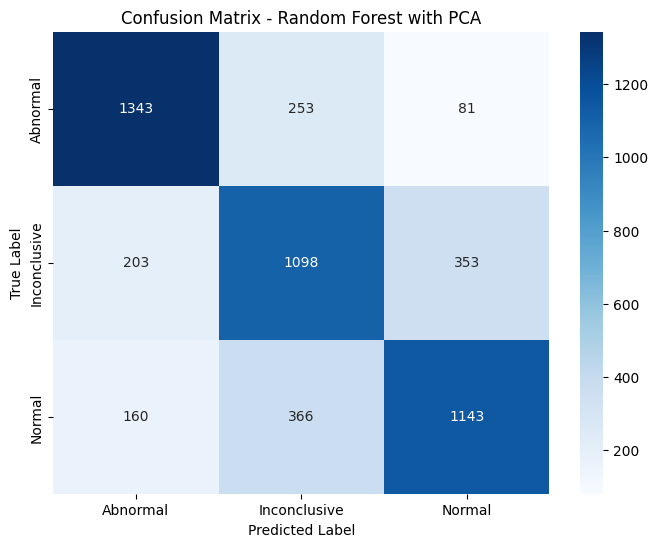

In [110]:
# Calculate the confusion matrix for the Random Forest model with PCA
cm_rf_pca = confusion_matrix(y_test, y_test_pred_pca)

# Plot the confusion matrix for Random Forest with PCA
plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf_pca, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix - Random Forest with PCA')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


## XGBoost

In [111]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report

# Step 1: Encode string labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Step 2: Split 80% train, 20% temp
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42
)

# Step 3: Split remaining 20% into 10% validation, 10% test
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
)

# Step 4: Define pipeline (preprocessor + PCA + XGBoost)
xgb_pipeline = Pipeline([
    ('preprocessor', preprocessor),  # your ColumnTransformer
    ('pca', PCA(n_components=0.95)),
    ('classifier', XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42))
])

# Step 5: Fit on training set
xgb_pipeline.fit(X_train, y_train)

# Step 6: Evaluate on validation set
y_val_pred = xgb_pipeline.predict(X_val)
print("Validation Performance:")
print(classification_report(le.inverse_transform(y_val), le.inverse_transform(y_val_pred)))

# Step 7: Final test evaluation
y_test_pred = xgb_pipeline.predict(X_test)
print("Test Performance:")
print(classification_report(le.inverse_transform(y_test), le.inverse_transform(y_test_pred)))


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [21:22:03] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Validation Performance:
              precision    recall  f1-score   support

    Abnormal       0.80      0.81      0.81      1677
Inconclusive       0.67      0.71      0.69      1655
      Normal       0.75      0.70      0.73      1668

    accuracy                           0.74      5000
   macro avg       0.74      0.74      0.74      5000
weighted avg       0.74      0.74      0.74      5000

Test Performance:
              precision    recall  f1-score   support

    Abnormal       0.81      0.80      0.80      1677
Inconclusive       0.63      0.71      0.67      1654
      Normal       0.75      0.68      0.72      1669

    accuracy                           0.73      5000
   macro avg       0.73      0.73      0.73      5000
weighted avg       0.73      0.73      0.73      5000



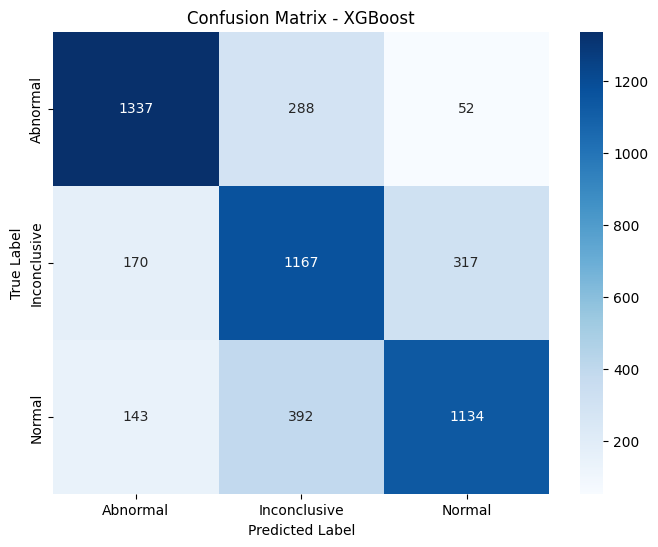

In [112]:
# prompt: visualize conf matrix

from sklearn.metrics import confusion_matrix

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_test_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix - XGBoost')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


# Logistic Regression (with PCA)

In [114]:
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression

# Pipeline with PCA
lr_pca_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('pca', PCA(n_components=0.95)),  # retain 95% variance
    ('classifier', LogisticRegression(max_iter=1000, random_state=42))
])

# Train
lr_pca_pipeline.fit(X_train, y_train)

# Predict
y_pred_pca = lr_pca_pipeline.predict(X_test)

# Evaluate
print("Logistic Regression (With PCA):")
print(classification_report(le.inverse_transform(y_test), le.inverse_transform(y_pred_pca)))

Logistic Regression (With PCA):
              precision    recall  f1-score   support

    Abnormal       0.72      0.72      0.72      1677
Inconclusive       0.60      0.63      0.61      1654
      Normal       0.59      0.56      0.58      1669

    accuracy                           0.64      5000
   macro avg       0.64      0.64      0.64      5000
weighted avg       0.64      0.64      0.64      5000



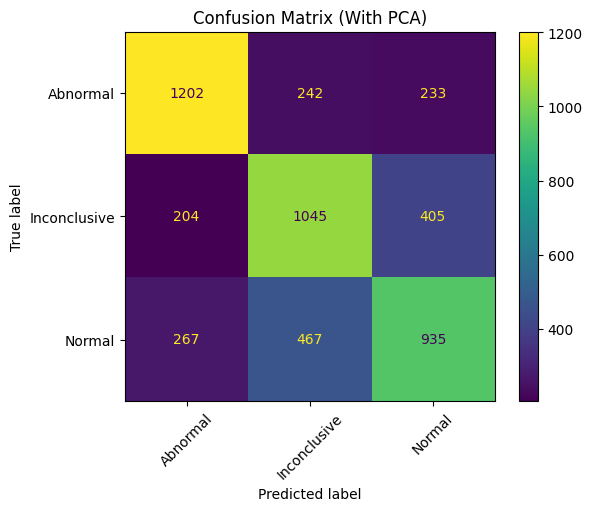

In [115]:
# Confusion matrix
disp = ConfusionMatrixDisplay.from_predictions(le.inverse_transform(y_test), le.inverse_transform(y_pred_pca))
plt.title("Confusion Matrix (With PCA)")
plt.xticks(rotation=45)
plt.grid(False)
plt.show()


# Logistic Regression (without PCA)

In [116]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Encode target
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Split 80/10/10
X_train, X_temp, y_train, y_temp = train_test_split(X, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

# Pipeline without PCA
lr_pipeline = Pipeline([
    ('preprocessor', preprocessor),  # your ColumnTransformer
    ('classifier', LogisticRegression(max_iter=1000, random_state=42))
])

# Train
lr_pipeline.fit(X_train, y_train)

# Predict
y_pred = lr_pipeline.predict(X_test)

# Evaluate
print("Logistic Regression (No PCA):")
print(classification_report(le.inverse_transform(y_test), le.inverse_transform(y_pred)))



Logistic Regression (No PCA):
              precision    recall  f1-score   support

    Abnormal       0.73      0.74      0.74      1677
Inconclusive       0.63      0.66      0.64      1654
      Normal       0.62      0.58      0.60      1669

    accuracy                           0.66      5000
   macro avg       0.66      0.66      0.66      5000
weighted avg       0.66      0.66      0.66      5000



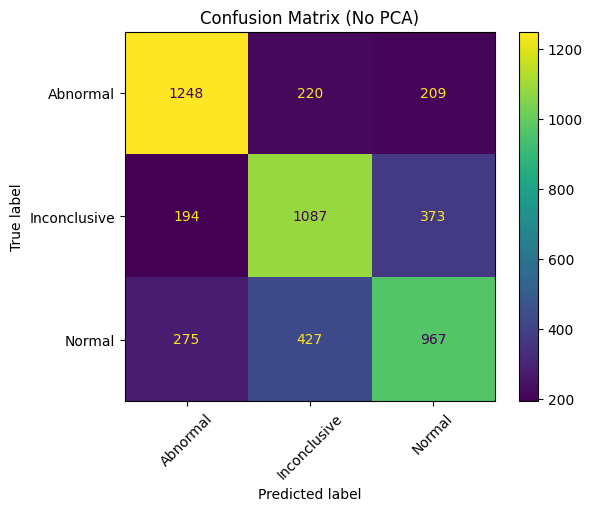

In [117]:
# Confusion matrix
disp = ConfusionMatrixDisplay.from_predictions(le.inverse_transform(y_test), le.inverse_transform(y_pred))
plt.title("Confusion Matrix (No PCA)")
plt.xticks(rotation=45)
plt.grid(False)
plt.show()


# SVM with linear and RBF kernel (NO PCA)

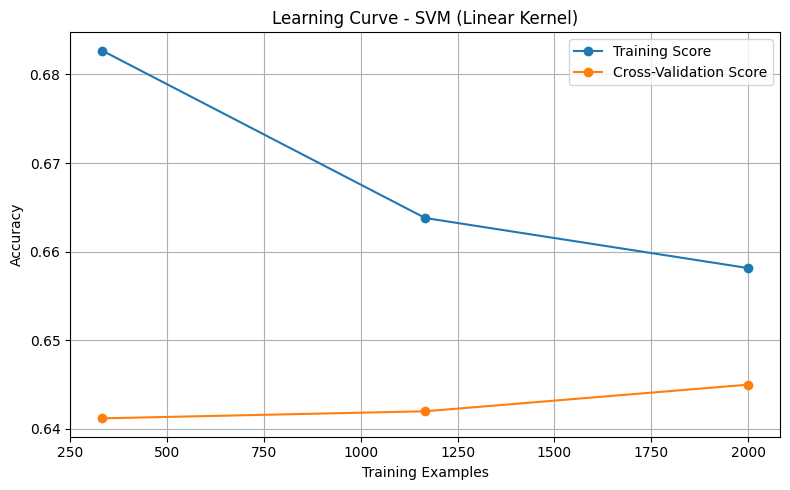

ModuleNotFoundError: No module named 'ace_tools'

In [119]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
import numpy as np

# Encode target variable
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Split the dataset (80% train, 10% validation, 10% test)
X_train, X_temp, y_train, y_temp = train_test_split(X, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

# Define SVM (Linear Kernel) pipeline
svm_linear_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', SVC(kernel='linear', probability=True, random_state=42))
])

# Fit and evaluate linear SVM
svm_linear_pipeline.fit(X_train, y_train)
y_pred_linear = svm_linear_pipeline.predict(X_test)

report_linear = classification_report(y_test, y_pred_linear, target_names=le.classes_, output_dict=True)
conf_matrix_linear = confusion_matrix(y_test, y_pred_linear)

# Plot learning curve
X_sample = X_train[:5000]
y_sample = y_train[:5000]

train_sizes, train_scores, val_scores = learning_curve(
    svm_linear_pipeline, X_sample, y_sample, cv=3, scoring='accuracy', n_jobs=-1,
    train_sizes=np.linspace(0.1, 0.6, 3), random_state=42
)

train_scores_mean = np.mean(train_scores, axis=1)
val_scores_mean = np.mean(val_scores, axis=1)

plt.figure(figsize=(8, 5))
plt.plot(train_sizes, train_scores_mean, 'o-', label='Training Score')
plt.plot(train_sizes, val_scores_mean, 'o-', label='Cross-Validation Score')
plt.title("Learning Curve - SVM (Linear Kernel)")
plt.xlabel("Training Examples")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



,precision,recall,f1-score,support
Abnormal,0.699544,0.731664,0.715243,1677.0000
Inconclusive,0.621118,0.665054,0.642336,1654.0000
Normal,0.595932,0.526663,0.559160,1669.0000
accuracy,0.641200,0.641200,0.641200,0.6412
macro avg,0.638865,0.641127,0.638913,5000.0000
weighted avg,0.639015,0.641200,0.639025,5000.0000


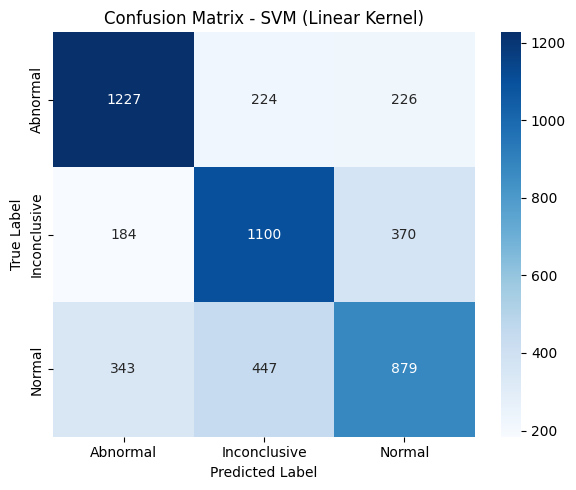

In [122]:
# Display classification report and confusion matrix
import pandas as pd
import seaborn as sns
from IPython.display import display

report_df = pd.DataFrame(report_linear).transpose()
display(report_df)

plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix_linear, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix - SVM (Linear Kernel)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()


In [125]:
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from pyswarms.single.global_best import GlobalBestPSO
import numpy as np

# Define objective function for PSO
def svm_objective(params):
    scores = []
    for C, gamma in params:
        model = Pipeline([
            ('preprocessor', preprocessor),
            ('svm', SVC(C=C, gamma=gamma, kernel='rbf'))
        ])
        # Negative accuracy since PSO minimizes
        score = cross_val_score(model, X_train, y_train, cv=3, scoring='accuracy').mean()
        scores.append(-score)
    return np.array(scores)


In [ ]:
!pip install pyswarms
from pyswarms.single.global_best import GlobalBestPSO
from sklearn.svm import SVC
# Define search space bounds: [C, gamma]
# C: 0.1 to 100, gamma: 0.0001 to 1
bounds = (np.array([0.1, 0.0001]), np.array([100, 1]))

# Initialize optimizer
optimizer = GlobalBestPSO(n_particles=10, dimensions=2, options={'c1': 0.5, 'c2': 0.3, 'w': 0.9}, bounds=bounds)

# Perform optimization
best_cost, best_pos = optimizer.optimize(svm_objective, iters=10)

print(f"Best parameters: C={best_pos[0]}, gamma={best_pos[1]}")


2025-05-27 23:04:19,391 - pyswarms.single.global_best - INFO - Optimize for 10 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/10

# SVM with linear and RBF kernel (WITH PCA)


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
import numpy as np

# Encode target variable
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Split the dataset (80% train, 10% validation, 10% test)
X_train, X_temp, y_train, y_temp = train_test_split(X, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

# Define SVM (Linear Kernel) pipeline
svm_linear_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('pca', PCA(n_components=0.95)),
    ('classifier', SVC(kernel='linear', probability=True, random_state=42))
])

# Fit and evaluate linear SVM
svm_linear_pipeline.fit(X_train, y_train)
y_pred_linear = svm_linear_pipeline.predict(X_test)

report_linear = classification_report(y_test, y_pred_linear, target_names=le.classes_, output_dict=True)
conf_matrix_linear = confusion_matrix(y_test, y_pred_linear)

train_scores_mean = np.mean(train_scores, axis=1)
val_scores_mean = np.mean(val_scores, axis=1)

plt.figure(figsize=(8, 5))
plt.plot(train_sizes, train_scores_mean, 'o-', label='Training Score')
plt.plot(train_sizes, val_scores_mean, 'o-', label='Cross-Validation Score')
plt.title("Learning Curve - SVM (Linear Kernel)")
plt.xlabel("Training Examples")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Display classification report and confusion matrix
import pandas as pd
import seaborn as sns
import ace_tools as tools

report_df = pd.DataFrame(report_linear).transpose()
tools.display_dataframe_to_user(name="SVM Linear Classification Report", dataframe=report_df)

plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix_linear, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix - SVM (Linear Kernel)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()


#MLP (With PCA)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder

# --- 1. Encode target labels ---
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# --- 2. 80/10/10 split ---
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
)

# --- 3. Define pipeline with MLP ---
mlp_pipeline = Pipeline([
    ('preprocessor', preprocessor),  # your ColumnTransformer
    ('pca', PCA(n_components=0.95)),
    ('classifier', MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, random_state=42))
])

# --- 4. Fit model ---
mlp_pipeline.fit(X_train, y_train)

# --- 5. Evaluate on validation ---
y_val_pred = mlp_pipeline.predict(X_val)
print("🔎 MLP - Validation Set Performance:")
print(classification_report(le.inverse_transform(y_val), le.inverse_transform(y_val_pred)))

# --- 6. Evaluate on test ---
y_test_pred = mlp_pipeline.predict(X_test)
print("✅ MLP - Test Set Performance:")
print(classification_report(le.inverse_transform(y_test), le.inverse_transform(y_test_pred)))


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input, LeakyReLU
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

# --- 1. Split the data ---
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.36, stratify=y, random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=4/9, stratify=y_temp, random_state=42
)
# This results in approx: 64% train, 20% val, 16% test

# --- 2. Encode labels ---
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_val_enc = le.transform(y_val)
y_test_enc = le.transform(y_test)

# One-hot encode for Keras
y_train_oh = to_categorical(y_train_enc)
y_val_oh = to_categorical(y_val_enc)
y_test_oh = to_categorical(y_test_enc)

# --- 3. Preprocess features using your existing pipeline ---
X_train_processed = preprocessor.fit_transform(X_train)
X_val_processed = preprocessor.transform(X_val)
X_test_processed = preprocessor.transform(X_test)

# --- 4. Build the MLP model ---
model = Sequential([
    Input(shape=(X_train_processed.shape[1],)),
    Dense(256),
    LeakyReLU(),
    Dropout(0.4),
    Dense(128),
    LeakyReLU(),
    Dropout(0.3),
    Dense(64),
    LeakyReLU(),
    Dense(3, activation='softmax')  # 3 classes
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

# --- 5. Train the model ---
history = model.fit(X_train_processed, y_train_oh,
                    validation_data=(X_val_processed, y_val_oh),
                    epochs=100,
                    batch_size=64,
                    callbacks=[early_stop, reduce_lr],
                    verbose=1)

# --- 6. Evaluate on test set ---
loss, accuracy = model.evaluate(X_test_processed, y_test_oh, verbose=0)
print(f"✅ Test Accuracy: {accuracy:.4f}")

# --- 7. Plot learning curves ---
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

# Optional: add PCA if needed
mlp_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    # ('pca', PCA(n_components=0.95)),  # Comment/remove this step if you don't want PCA
    ('mlp', KerasClassifier(
        model=build_mlp,
        epochs=100,
        batch_size=64,
        verbose=1,
        callbacks=[
            EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
            ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)
        ]
    ))
])


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# Encode labels
le = LabelEncoder()
y_enc = le.fit_transform(y)
y_cat = to_categorical(y_enc)

# Split data
X_train, X_temp, y_train, y_temp = train_test_split(X, y_cat, test_size=0.36, stratify=y_cat.argmax(axis=1), random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.445, stratify=y_temp.argmax(axis=1), random_state=42)


In [ ]:
mlp_pipeline.fit(X_train, y_train, mlp__validation_data=(X_val, y_val))


#MLP without PCA


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder

# --- 1. Encode target labels ---
le = LabelEncoder()
y_encoded = le.fit_transform(y)

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.36, stratify=y, random_state=42
)

# Second split: of the 36%, split into 20% val and 16% test
# 20% / 36% ≈ 0.555, so val = 55.5% of temp, test = 44.5% of temp
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.445, stratify=y_temp, random_state=42
)

# --- 3. Define pipeline with MLP ---
mlp_pipeline = Pipeline([
    ('preprocessor', preprocessor),  # your ColumnTransformer
    ('classifier', MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, random_state=42))
])

# --- 4. Fit model ---
mlp_pipeline.fit(X_train, y_train)

# --- 5. Evaluate on validation ---
y_val_pred = mlp_pipeline.predict(X_val)
print("🔎 MLP - Validation Set Performance:")
print(classification_report(le.inverse_transform(y_val), le.inverse_transform(y_val_pred)))

# --- 6. Evaluate on test ---
y_test_pred = mlp_pipeline.predict(X_test)
print("✅ MLP - Test Set Performance:")
print(classification_report(le.inverse_transform(y_test), le.inverse_transform(y_test_pred)))


# Testing Data

In [ ]:
import pandas as pd

# 1. Load test data
new_data = pd.read_csv('/content/drive/MyDrive/healthcare/test data.csv')

# 2. Create 'Length of Stay'
new_data['Date of Admission'] = pd.to_datetime(new_data['Date of Admission'], dayfirst=True)
new_data['Discharge Date'] = pd.to_datetime(new_data['Discharge Date'], dayfirst=True)
new_data['Length of Stay'] = (new_data['Discharge Date'] - new_data['Date of Admission']).dt.days

# 3. Drop unnecessary columns
X_new = new_data.drop(columns=['Name', 'Date of Admission', 'Discharge Date', 'Room Number', 'Test Results'], errors='ignore')

# 4. Predict using trained pipeline
y_pred = xgb_pipeline.predict(X_new)

# 5. Decode labels if necessary
if 'le' in globals():
    y_pred = le.inverse_transform(y_pred)

# 6. Create submission DataFrame
submission_df = pd.DataFrame({
    'ID': new_data['ID'],  # Ensure 'ID' exists in the original test data
    'Test Results': y_pred
})

# 7. Save and download
submission_df.to_csv("submission.csv", index=False)

from google.colab import files
files.download("submission.csv")
